# Load Image

In [1]:
import torch
import torchvision.transforms.v2 as T

from torchvision.datasets import ImageFolder

transforms = T.Compose([
    T.ToImage(),
    T.Resize((224, 224)),
    T.ToDtype(torch.float32, scale = True),
    T.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
])

dataset = ImageFolder(root = "./dataset/train/", transform = transforms)

# Set available device

In [2]:
from torchvision.models import resnet50, ResNet50_Weights

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Use {device} to train...\n")

Use mps to train...



# Train model & draw confusion matrix

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def draw_confusion_matrix(count, fold, epoch):
    confusion_matrix = pd.DataFrame(count, index = dataset.classes, columns = dataset.classes)
    ax = sns.heatmap(confusion_matrix, cmap = "Blues", fmt = ".5g", annot = True)
    ax.tick_params(axis = "x")
    ax.tick_params(axis = "y")
    plt.title(f"Confusion Matrix of Fold {fold} Epoch {epoch}")
    plt.savefig(f"k-fold validation/confusion matrix_fold {fold}_epoch {epoch}.png", bbox_inches = "tight")
    plt.title("")
    plt.show()

In [4]:
import torch.nn.functional as F

from torch.optim import Adam
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler, DataLoader
from tqdm.notebook import tqdm

def train(device, dataset, n_classes, n_folds, n_epochs):
    kfold = KFold(n_splits = n_folds, shuffle = True)
    train_loss_record, val_loss_record, train_acc, val_acc = [], [], [], []

    for fold, (train_ids, valid_ids) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1} / {n_folds}")

        # sample elements of dataset
        train_subsampler = SubsetRandomSampler(train_ids)
        valid_subsampler = SubsetRandomSampler(valid_ids)

        # define data loader for training set and validation set
        train_loader = DataLoader(dataset, batch_size = 32, sampler = train_subsampler)
        valid_loader = DataLoader(dataset, batch_size = 32, sampler = valid_subsampler)

        # initialize model
        model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2).to(device)
        for parameter in model.parameters():
            parameter.require_grad = False
        model.fc = torch.nn.Linear(2048, len(dataset.classes)).to(device)

        optimizer = Adam(model.fc.parameters(), lr = 0.001)
        
        record1, record2 = [], []
        for epoch in range(n_epochs):
            print("-" * 100)
            model.train()
            train_loss = train_corrects = 0
    
            # training
            with tqdm(train_loader) as tepoch:
                for inputs, targets in tepoch:
                    # transfer data to gpu
                    inputs = inputs.to(device)
                    targets = targets.to(device)
            
                    # forward
                    outputs = model(inputs)
                    loss = F.cross_entropy(outputs, targets)
            
                    # backward
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        
                    _, preds = torch.max(outputs, 1)
                    train_loss += loss.item() * inputs.size(0)
                    train_corrects += torch.sum(preds == targets.data)
    
                    tepoch.set_description(f"Epoch {epoch + 1}")
                    tepoch.set_postfix(loss = loss.item())
                
            epoch_loss = train_loss / (len(train_loader.dataset) * (n_folds - 1) / n_folds)
            epoch_acc = train_corrects / (len(train_loader.dataset) * (n_folds - 1) / n_folds)
            record1.append(epoch_loss)
            if epoch == n_epochs - 1:
                train_acc.append(epoch_acc)
            print(f"Train - loss: {epoch_loss: .4f}, accuracy: {epoch_acc: .4f}")
    
            # validation
            valid_loss = valid_corrects = 0
            count = [[0] * n_classes for _ in range(n_classes)]
            model.eval()
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    # tranfer data to gpu
                    inputs = inputs.to(device)
                    targets = targets.to(device)
    
                    # forward
                    outputs = model(inputs)
                    loss = F.cross_entropy(outputs, targets)
    
                    # evaluation
                    _, preds = torch.max(outputs, 1)
                    for i in range(len(preds)):
                        count[preds[i].item()][targets[i].item()] += 1
                    valid_loss += loss.item() * inputs.size(0)
                    valid_corrects += torch.sum(preds == targets.data)
    
            epoch_loss = valid_loss / (len(valid_loader.dataset) / n_folds)
            epoch_acc = valid_corrects / (len(valid_loader.dataset) / n_folds)
            record2.append(epoch_loss)
            if epoch == n_epochs - 1:
                val_acc.append(epoch_acc)
            print(f"Validation - loss: {epoch_loss: .4f}, accuracy: {epoch_acc: .4f}")
            draw_confusion_matrix(count, fold + 1, epoch + 1)
            
            print("-" * 100)

        torch.save(model.state_dict(), f"model_weights/model_weights_fold {fold + 1} (k-fold validation).pth")
        train_loss_record.append(record1)
        val_loss_record.append(record2)

    return train_loss_record, val_loss_record, train_acc, val_acc

Fold 1 / 5
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.7851, accuracy:  0.4787
Validation - loss:  1.3798, accuracy:  0.6358


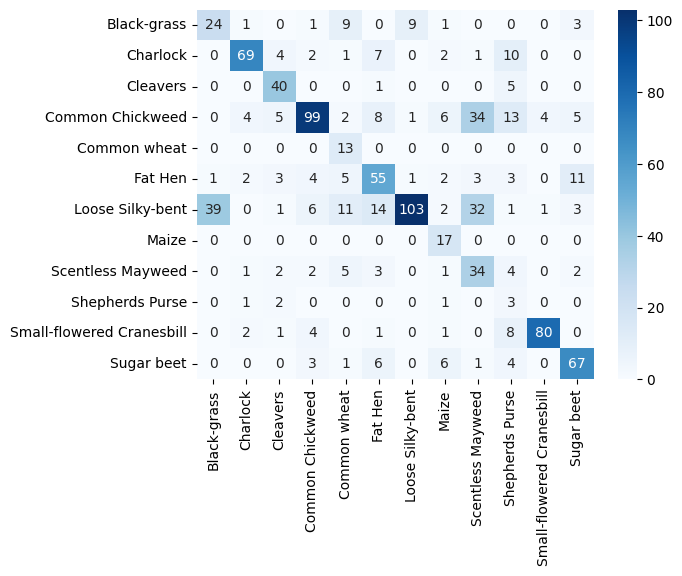

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.1627, accuracy:  0.6979
Validation - loss:  1.1185, accuracy:  0.7042


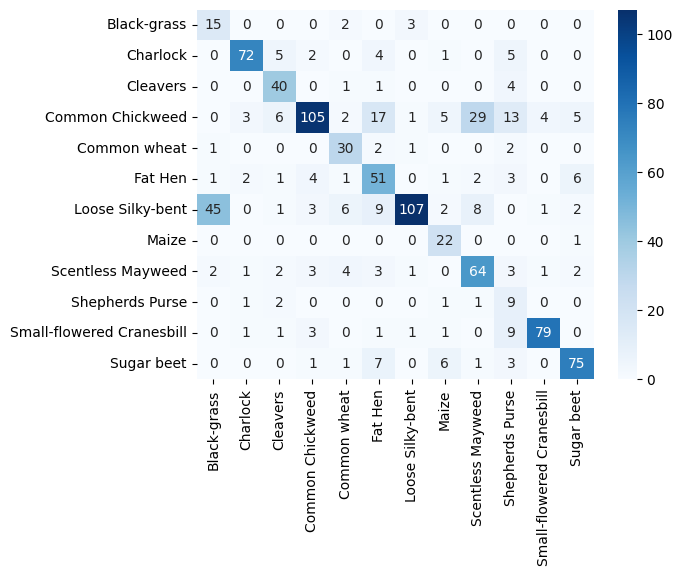

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.9120, accuracy:  0.7668
Validation - loss:  0.9216, accuracy:  0.7495


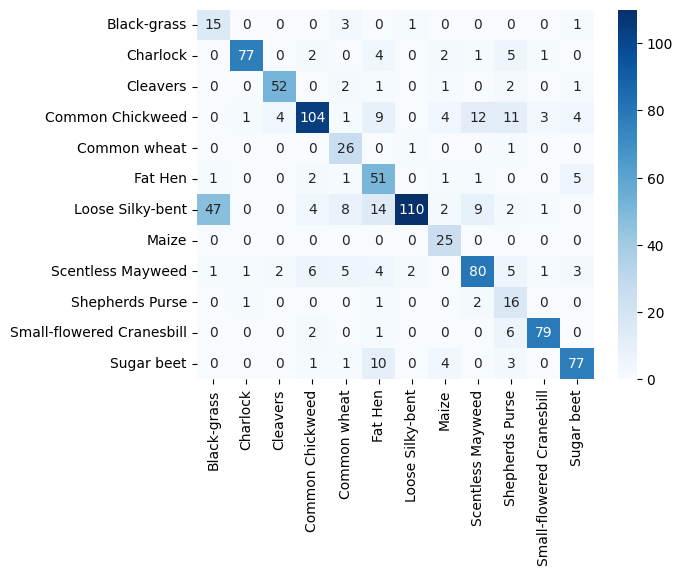

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.7603, accuracy:  0.8145
Validation - loss:  0.8478, accuracy:  0.7568


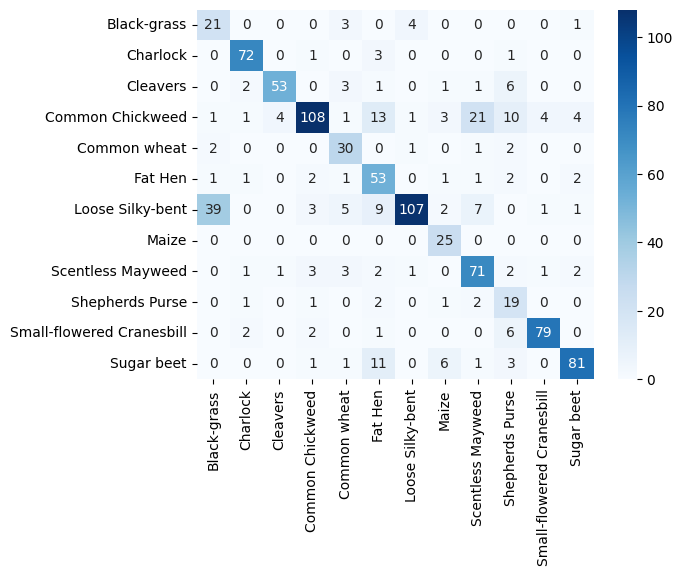

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.6601, accuracy:  0.8445
Validation - loss:  0.7772, accuracy:  0.7821


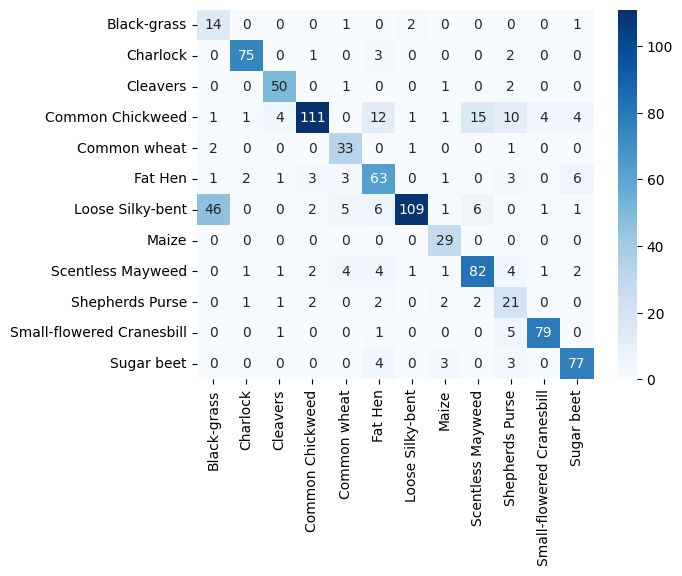

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.6007, accuracy:  0.8505
Validation - loss:  0.7202, accuracy:  0.7937


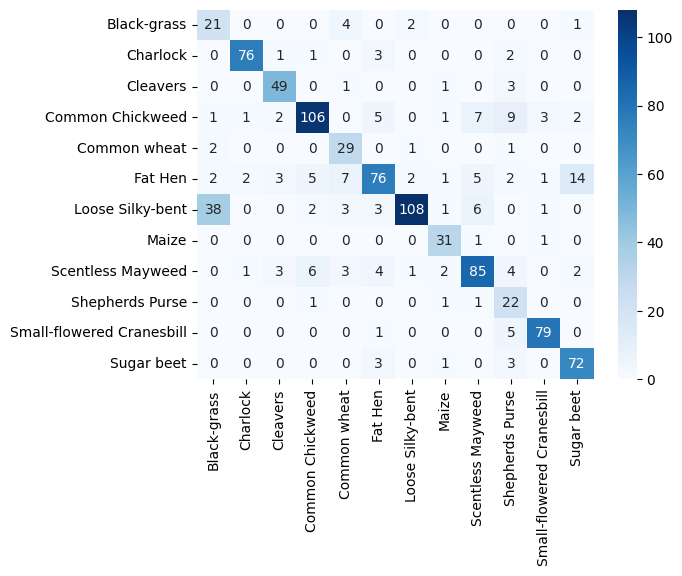

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5327, accuracy:  0.8674
Validation - loss:  0.6755, accuracy:  0.8032


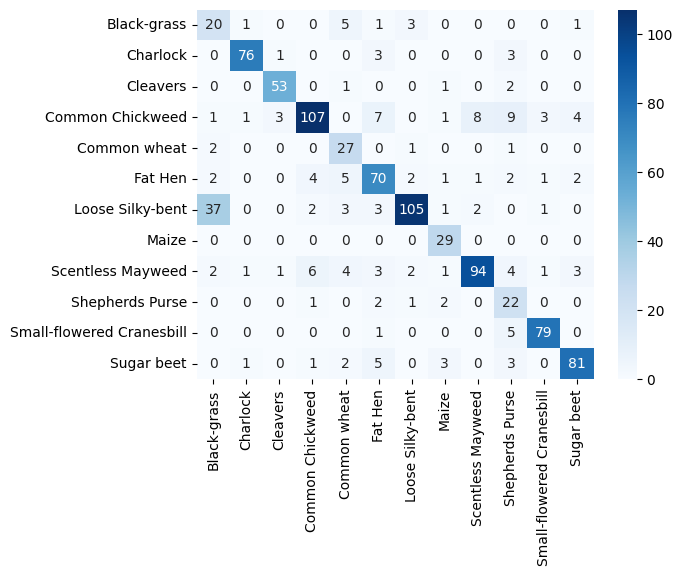

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4880, accuracy:  0.8768
Validation - loss:  0.6395, accuracy:  0.8074


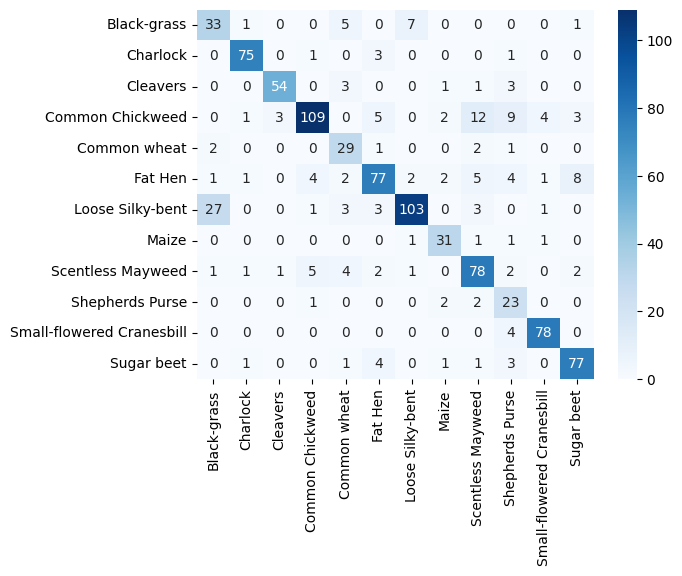

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4607, accuracy:  0.8903
Validation - loss:  0.6375, accuracy:  0.8000


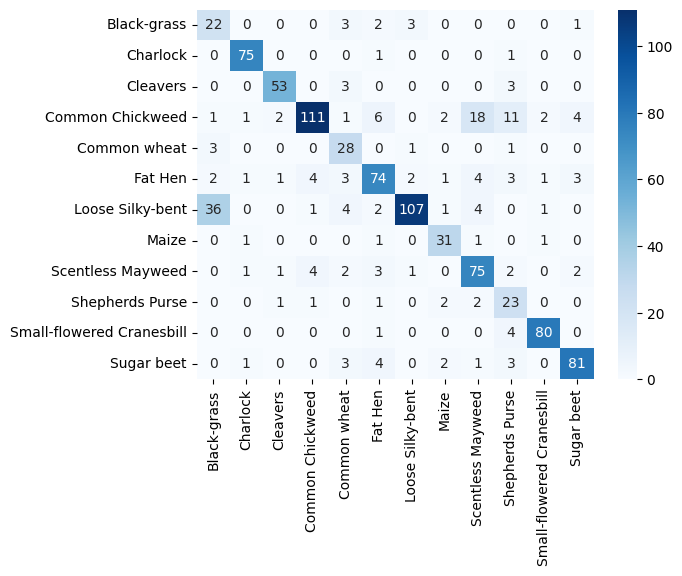

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4265, accuracy:  0.8968
Validation - loss:  0.6125, accuracy:  0.8095


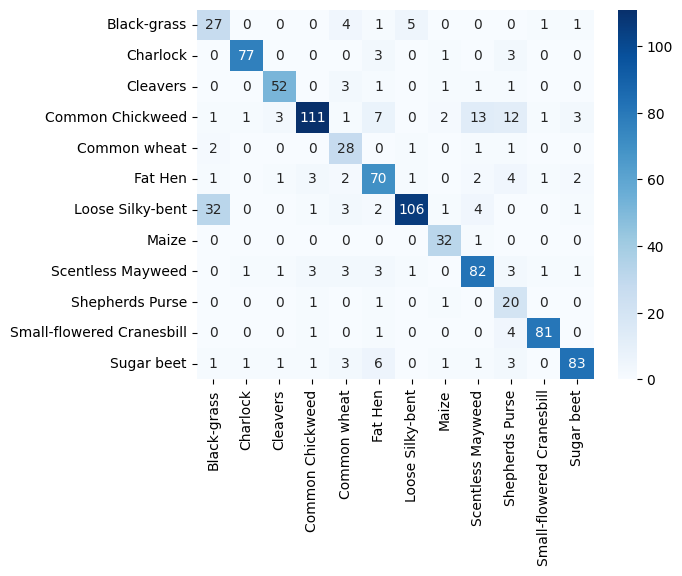

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3973, accuracy:  0.9079
Validation - loss:  0.5892, accuracy:  0.8105


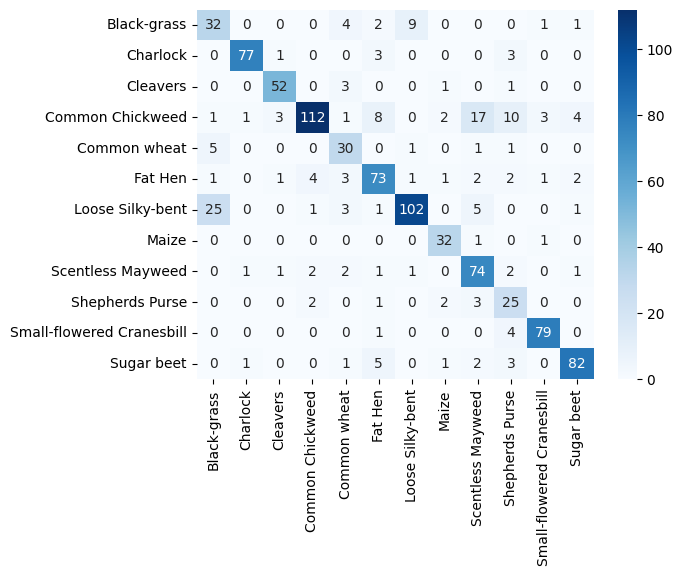

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3810, accuracy:  0.9087
Validation - loss:  0.5935, accuracy:  0.8084


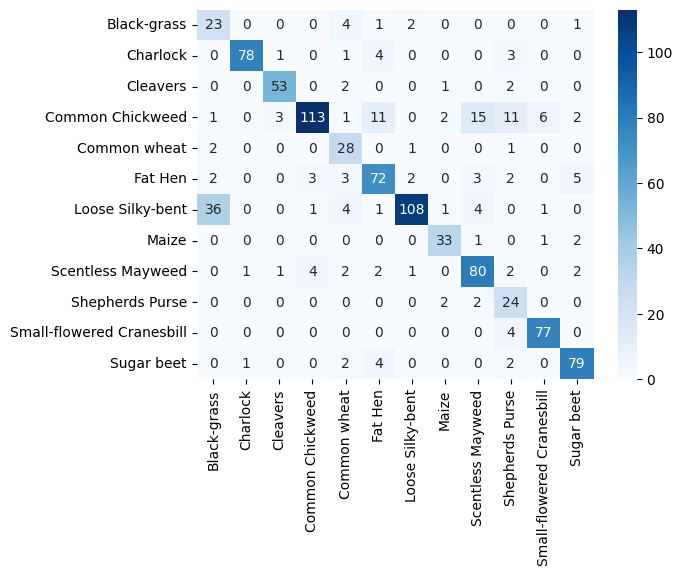

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3521, accuracy:  0.9179
Validation - loss:  0.5442, accuracy:  0.8326


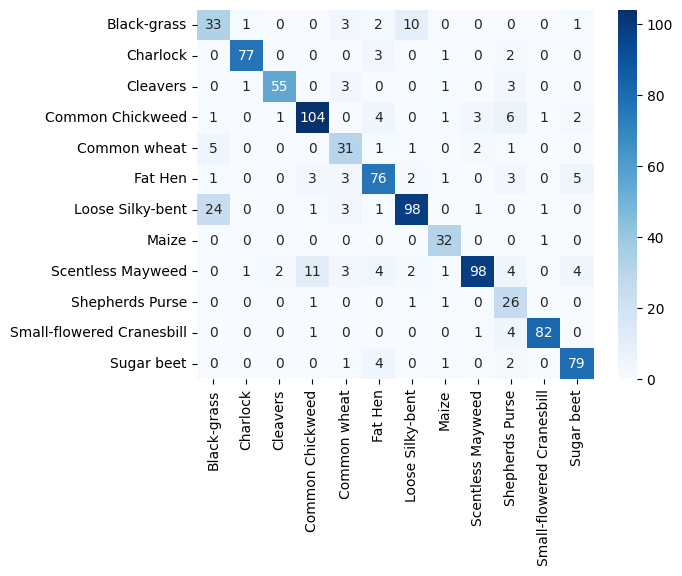

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3283, accuracy:  0.9218
Validation - loss:  0.5519, accuracy:  0.8200


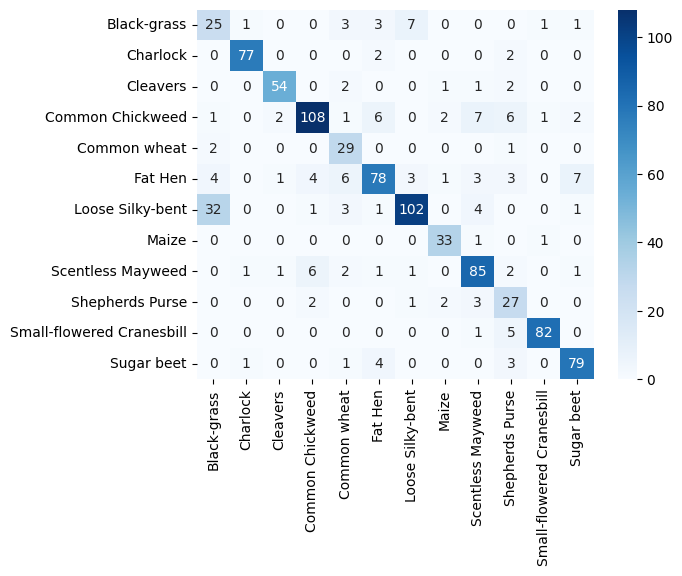

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3162, accuracy:  0.9279
Validation - loss:  0.5527, accuracy:  0.8263


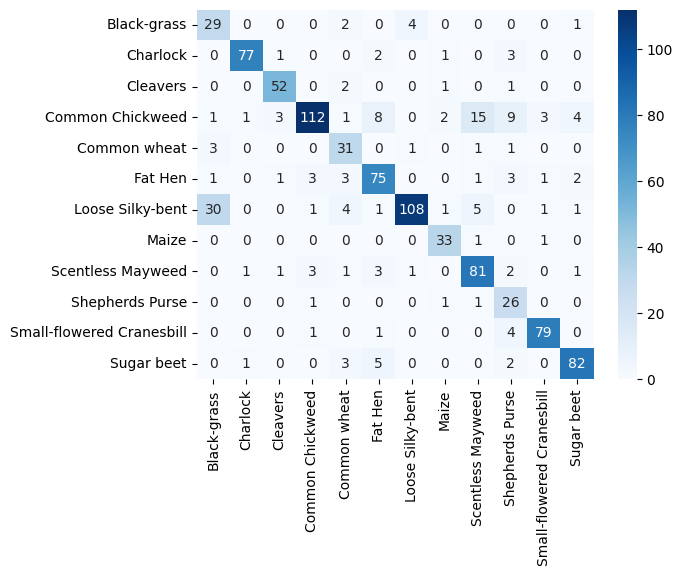

----------------------------------------------------------------------------------------------------
Fold 2 / 5
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.7839, accuracy:  0.4816
Validation - loss:  1.3662, accuracy:  0.6853


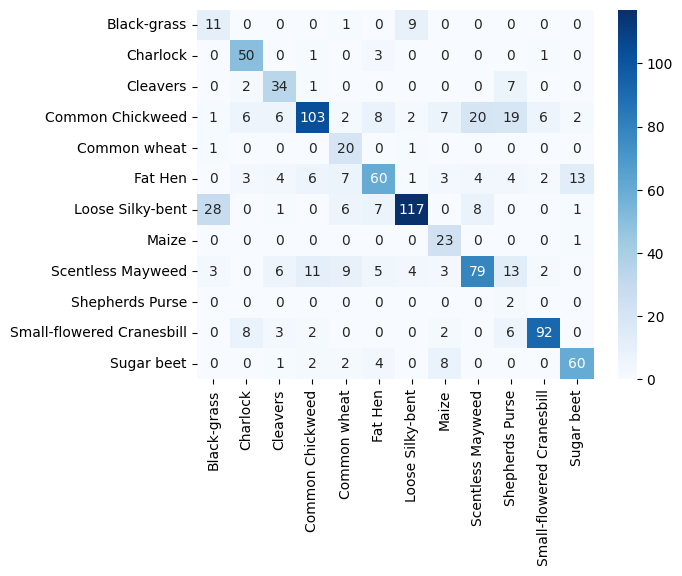

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.1637, accuracy:  0.7021
Validation - loss:  1.0536, accuracy:  0.7611


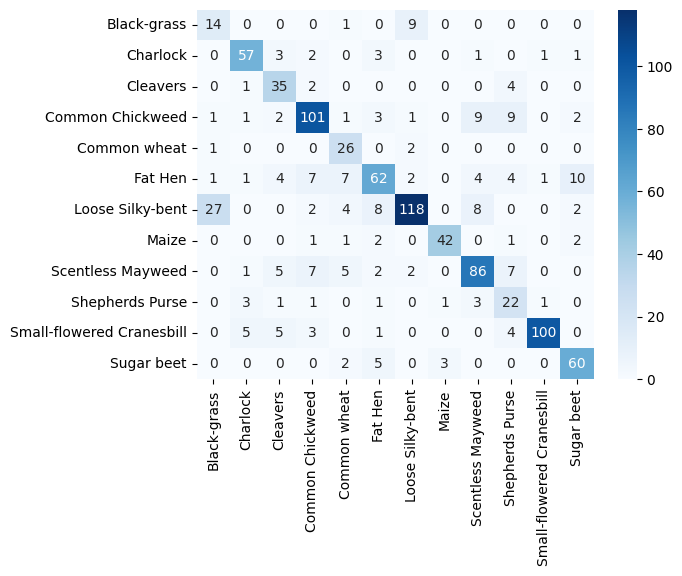

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.9167, accuracy:  0.7689
Validation - loss:  0.8954, accuracy:  0.7463


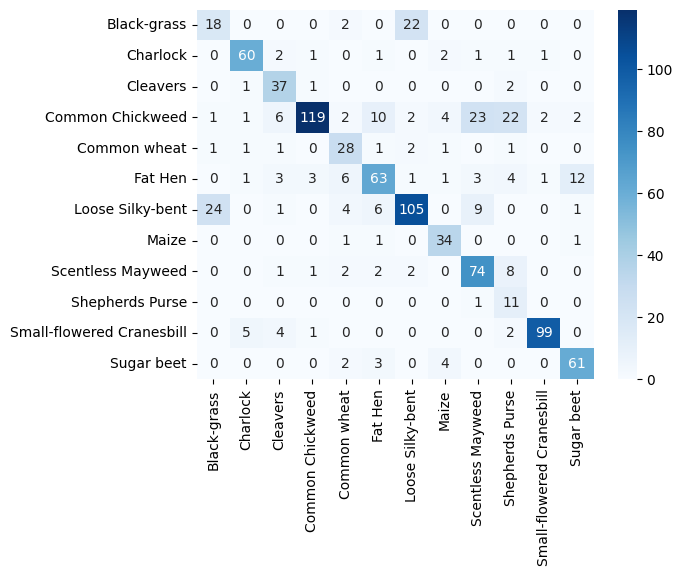

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.7859, accuracy:  0.8042
Validation - loss:  0.8048, accuracy:  0.7884


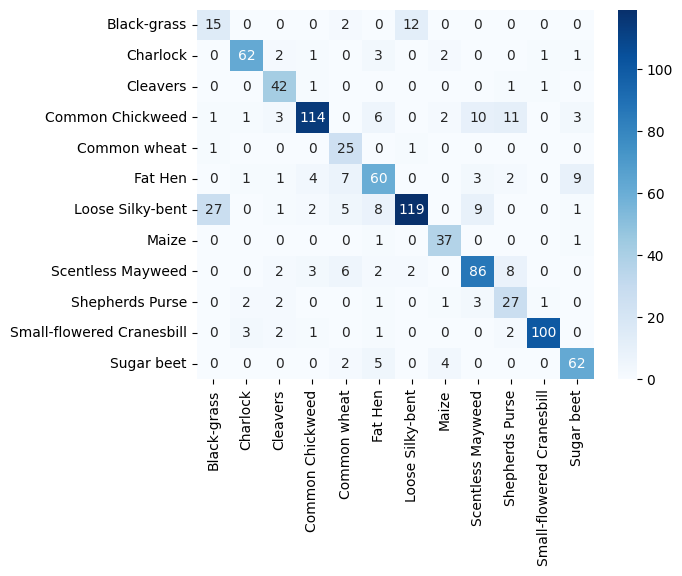

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.6679, accuracy:  0.8361
Validation - loss:  0.7288, accuracy:  0.7884


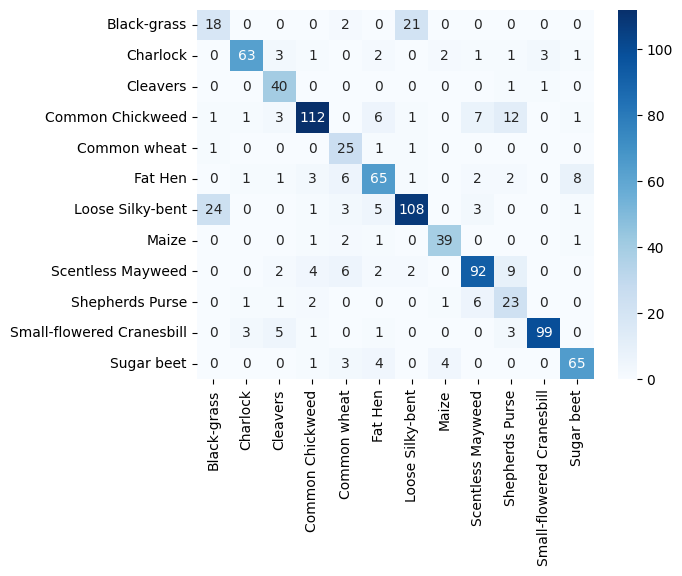

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5958, accuracy:  0.8634
Validation - loss:  0.7044, accuracy:  0.7958


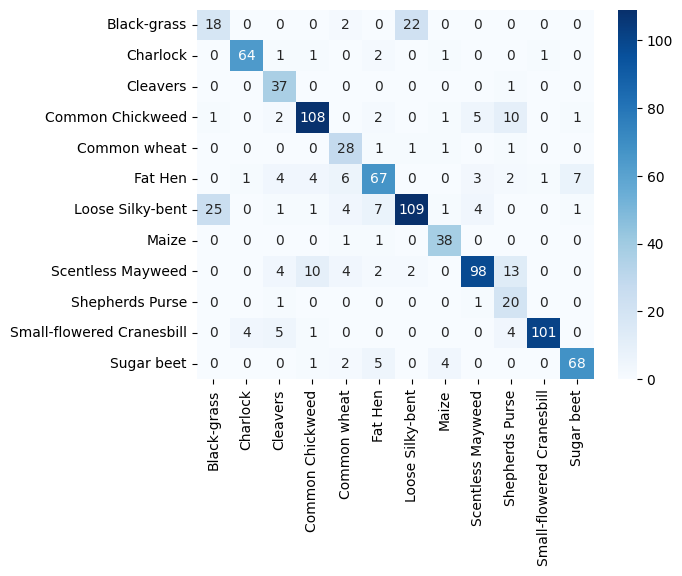

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5353, accuracy:  0.8737
Validation - loss:  0.6712, accuracy:  0.8053


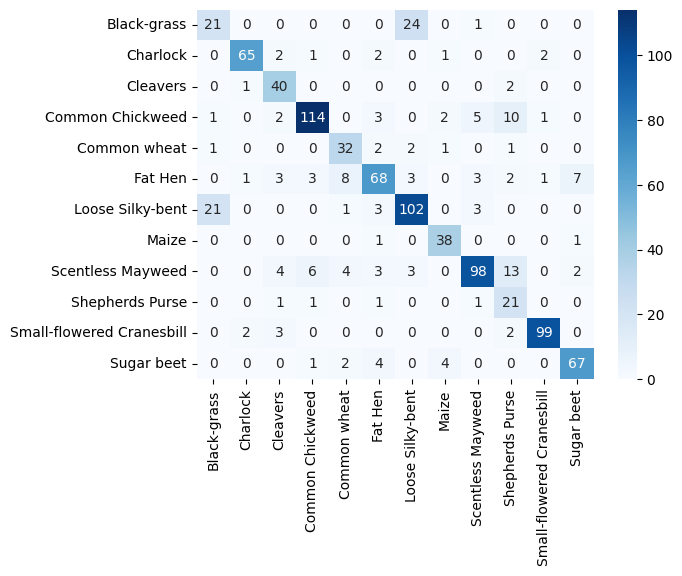

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4918, accuracy:  0.8813
Validation - loss:  0.6518, accuracy:  0.8137


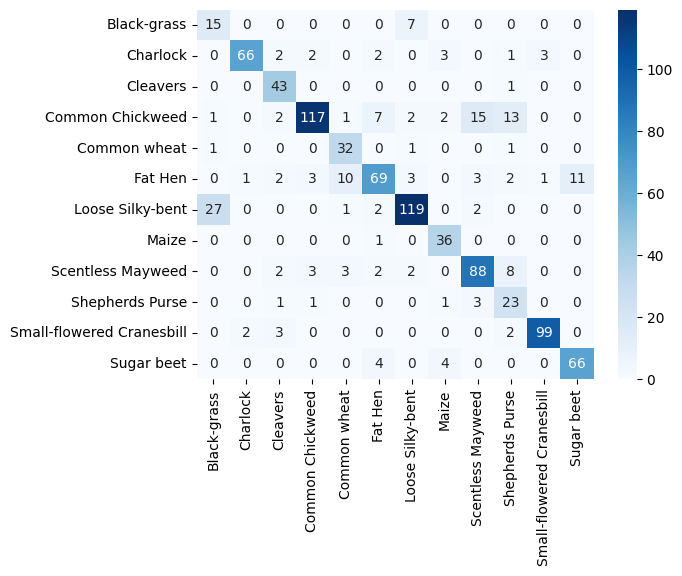

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4703, accuracy:  0.8861
Validation - loss:  0.6279, accuracy:  0.8326


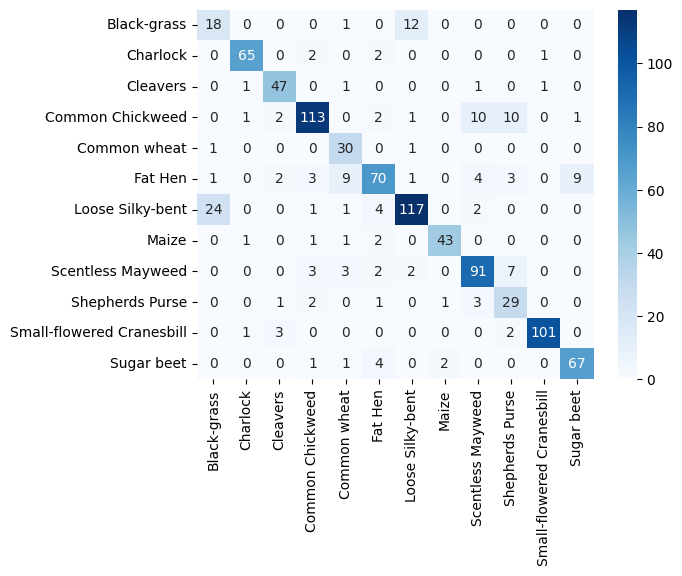

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4267, accuracy:  0.9021
Validation - loss:  0.6001, accuracy:  0.8295


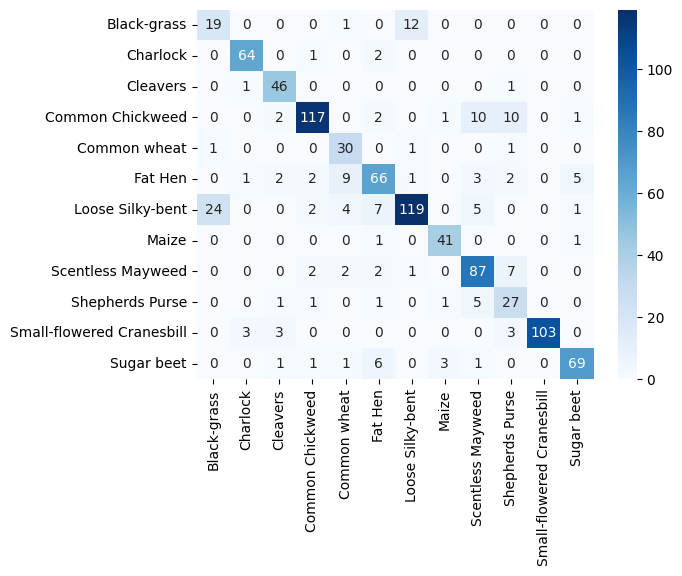

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3959, accuracy:  0.9063
Validation - loss:  0.5804, accuracy:  0.8232


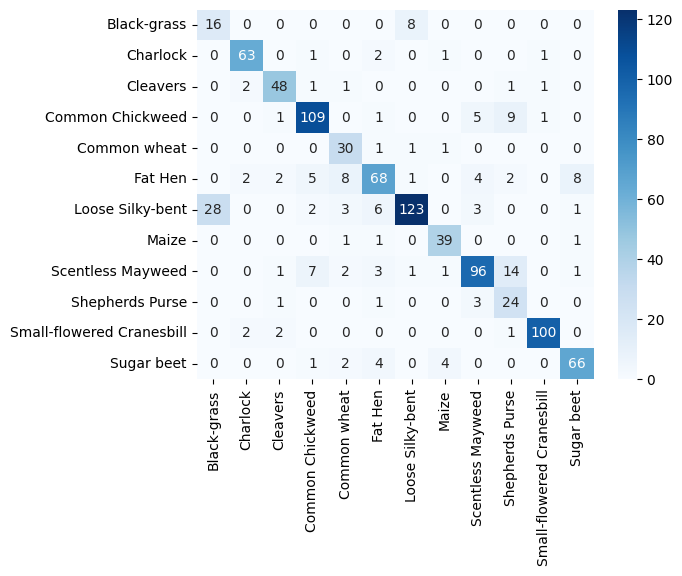

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3835, accuracy:  0.9121
Validation - loss:  0.5747, accuracy:  0.8326


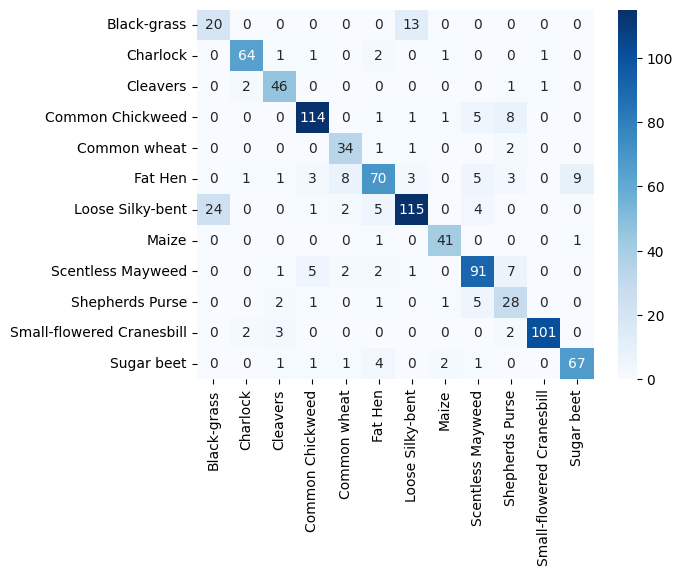

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3534, accuracy:  0.9274
Validation - loss:  0.5517, accuracy:  0.8168


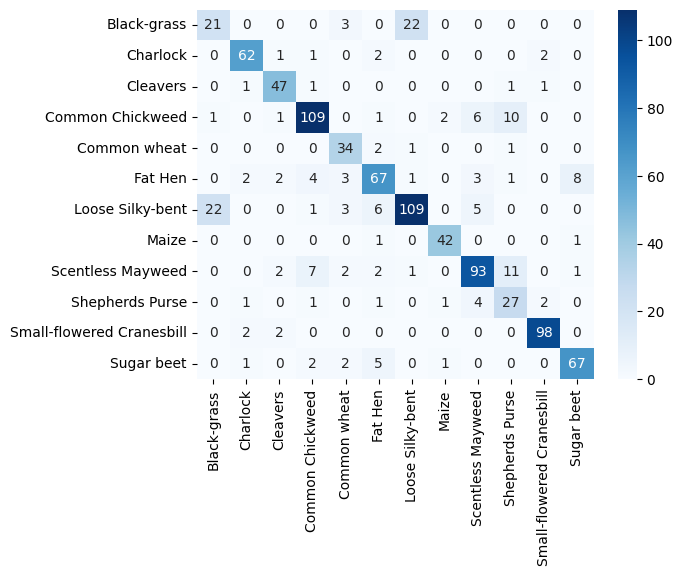

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3338, accuracy:  0.9255
Validation - loss:  0.5523, accuracy:  0.8347


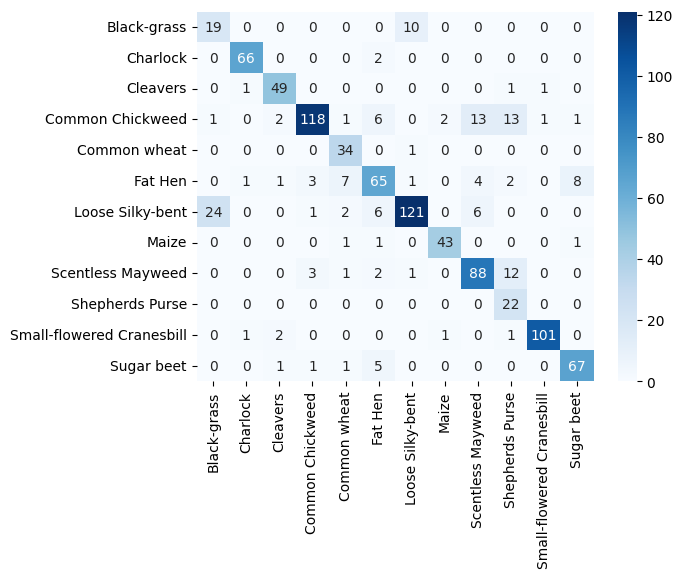

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3288, accuracy:  0.9279
Validation - loss:  0.5202, accuracy:  0.8411


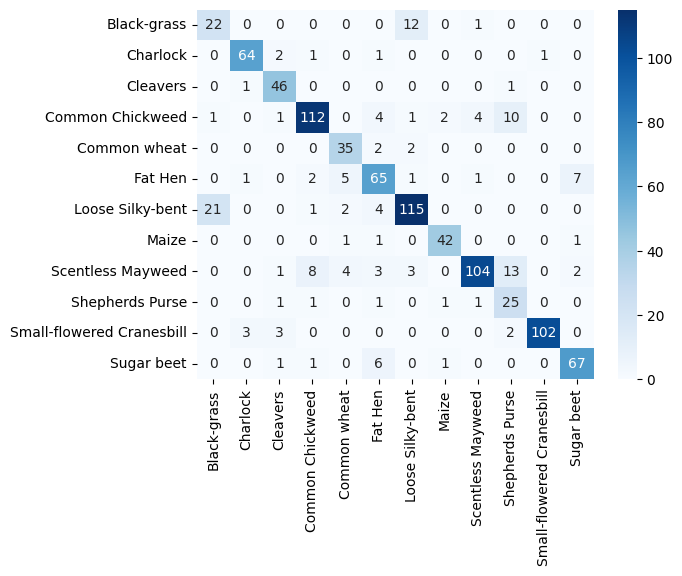

----------------------------------------------------------------------------------------------------
Fold 3 / 5
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.8113, accuracy:  0.4621
Validation - loss:  1.3642, accuracy:  0.6768


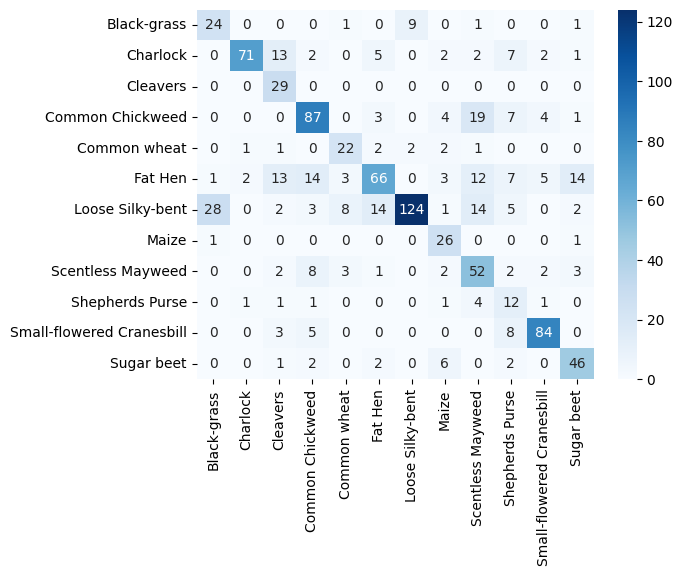

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.1805, accuracy:  0.7016
Validation - loss:  1.0372, accuracy:  0.7389


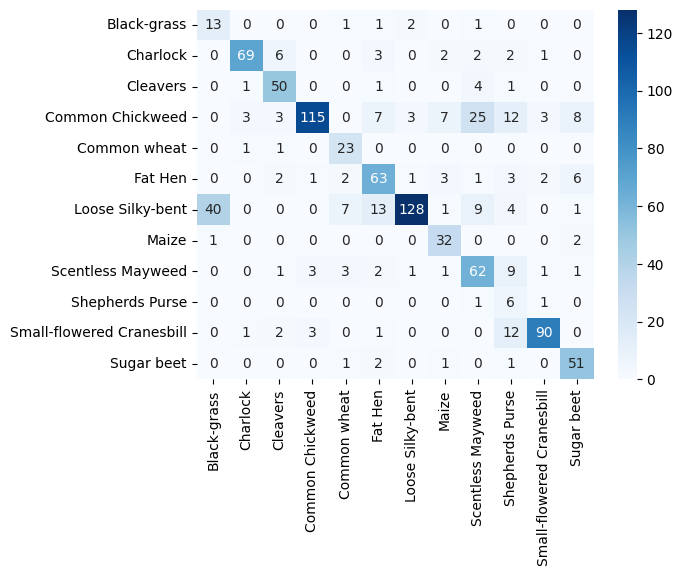

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.9360, accuracy:  0.7511
Validation - loss:  0.8706, accuracy:  0.7884


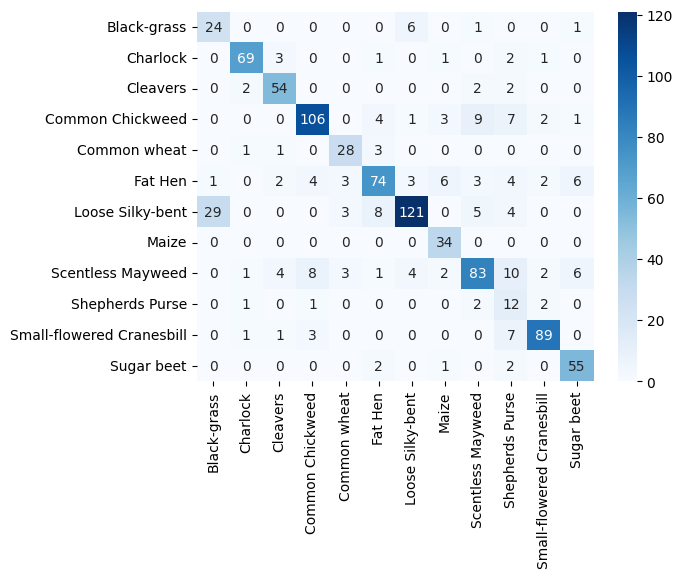

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.7676, accuracy:  0.8145
Validation - loss:  0.7661, accuracy:  0.8032


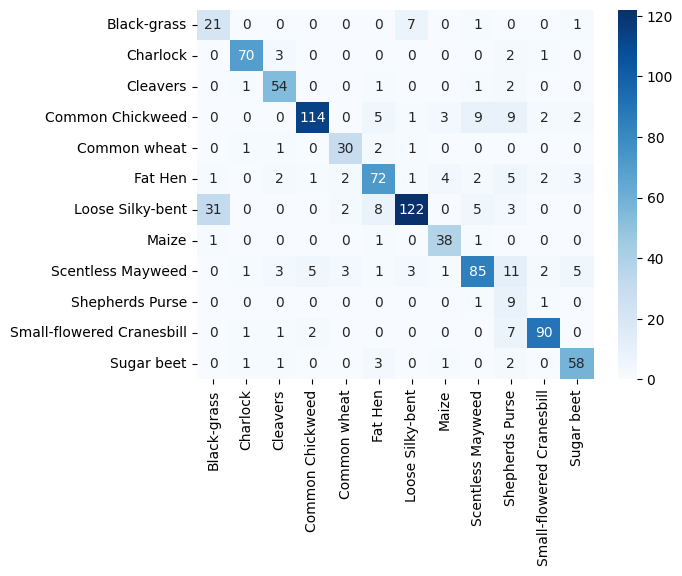

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.6767, accuracy:  0.8355
Validation - loss:  0.6884, accuracy:  0.8147


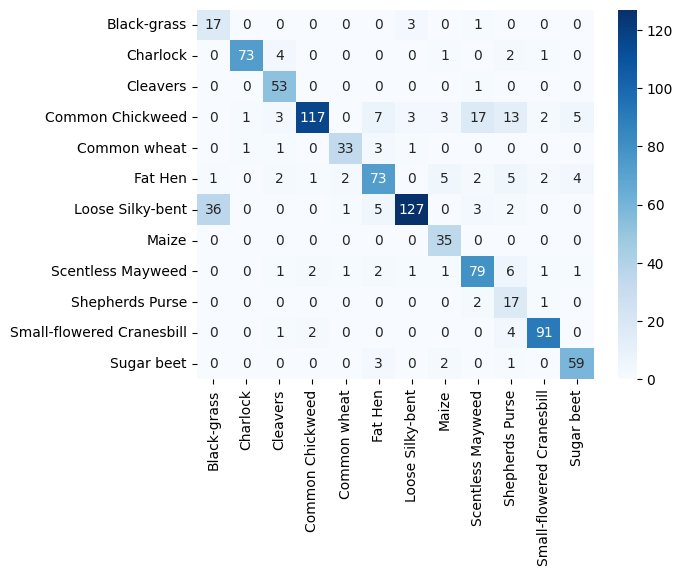

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5978, accuracy:  0.8589
Validation - loss:  0.6560, accuracy:  0.8211


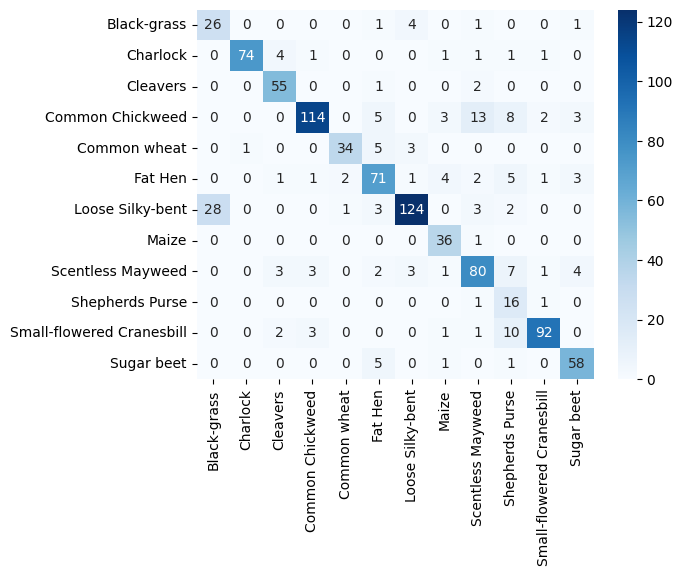

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5526, accuracy:  0.8668
Validation - loss:  0.6267, accuracy:  0.8232


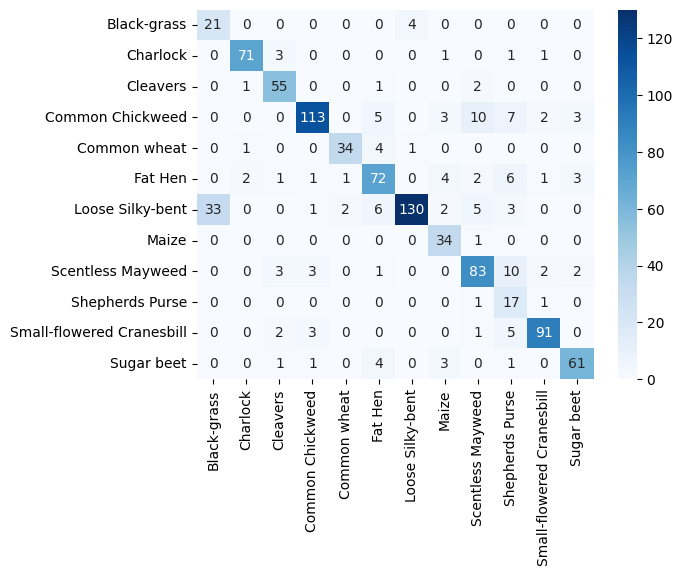

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5108, accuracy:  0.8811
Validation - loss:  0.5932, accuracy:  0.8411


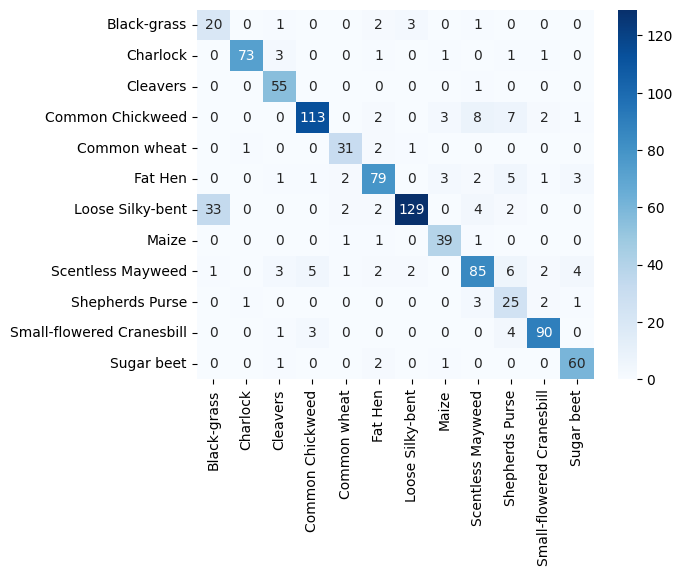

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4744, accuracy:  0.8879
Validation - loss:  0.5455, accuracy:  0.8411


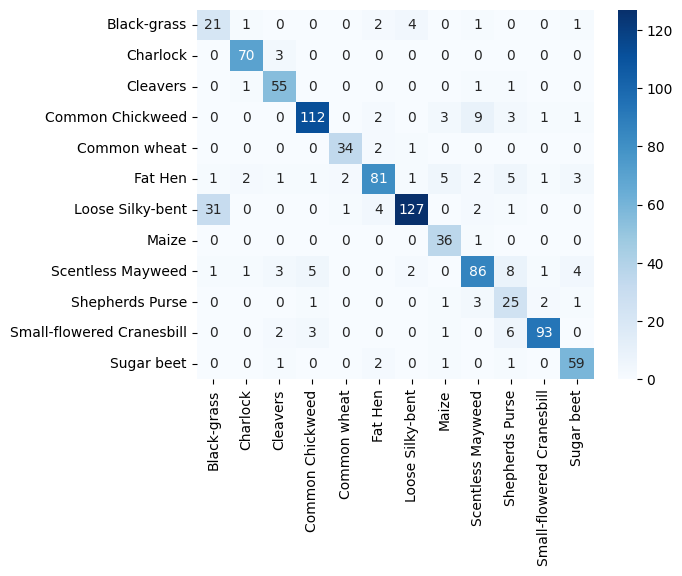

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4346, accuracy:  0.8976
Validation - loss:  0.5565, accuracy:  0.8484


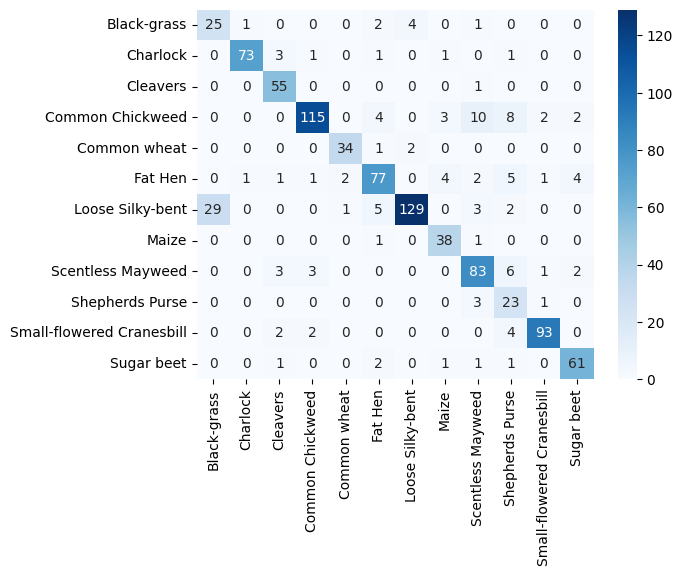

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4104, accuracy:  0.9050
Validation - loss:  0.5194, accuracy:  0.8474


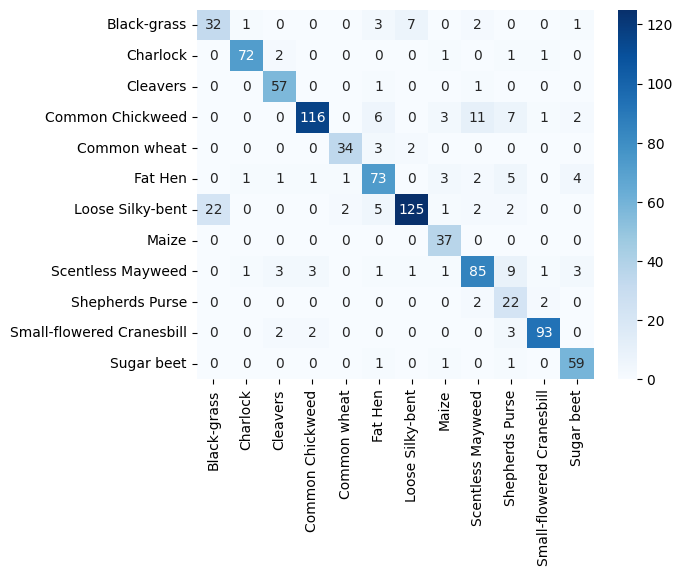

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3780, accuracy:  0.9179
Validation - loss:  0.4993, accuracy:  0.8400


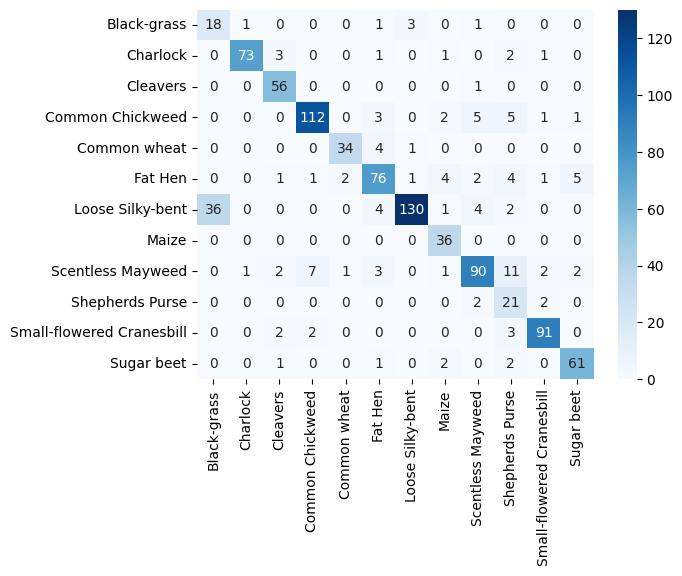

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3630, accuracy:  0.9147
Validation - loss:  0.5025, accuracy:  0.8463


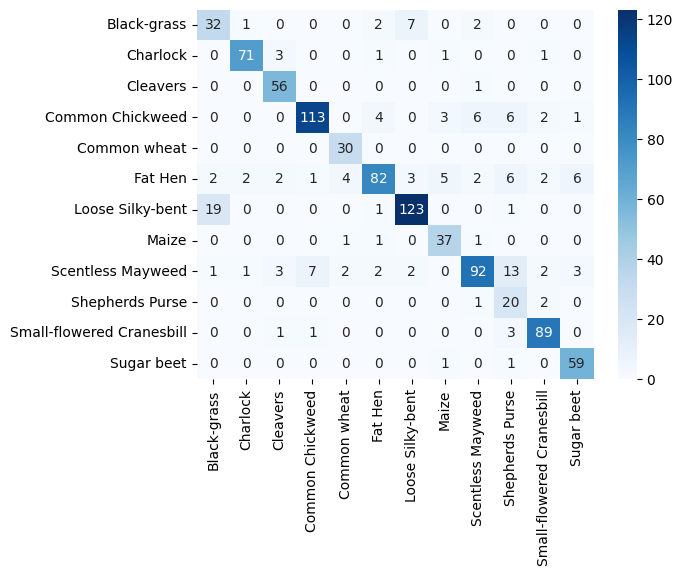

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3382, accuracy:  0.9237
Validation - loss:  0.4720, accuracy:  0.8526


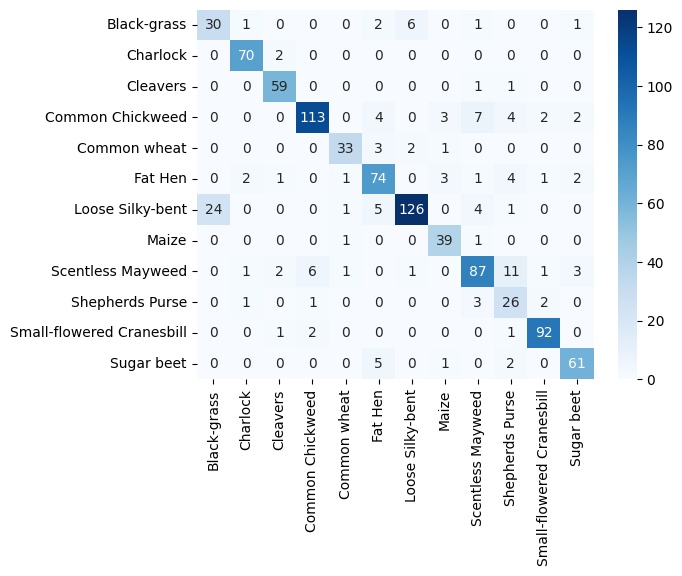

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3205, accuracy:  0.9332
Validation - loss:  0.4694, accuracy:  0.8642


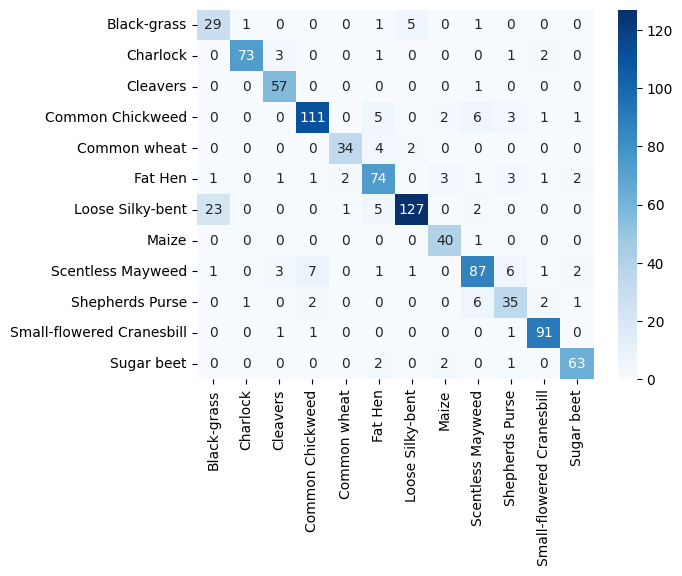

----------------------------------------------------------------------------------------------------
Fold 4 / 5
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.7993, accuracy:  0.4768
Validation - loss:  1.3819, accuracy:  0.6274


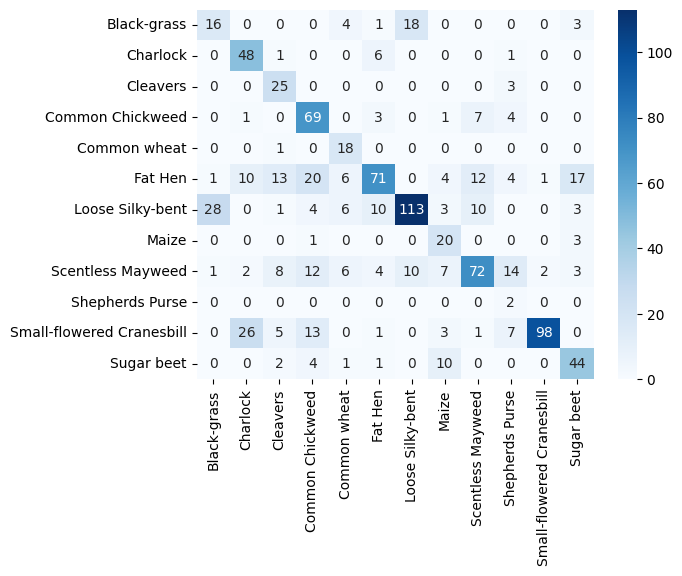

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.1597, accuracy:  0.7074
Validation - loss:  1.0869, accuracy:  0.7211


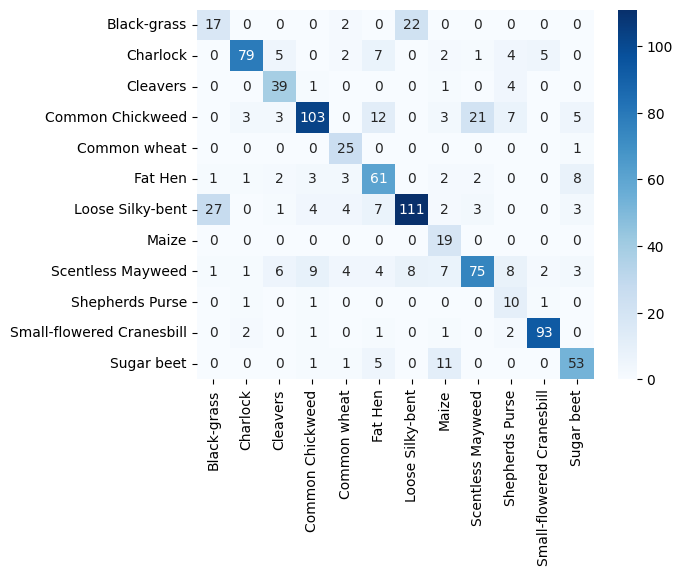

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.9064, accuracy:  0.7716
Validation - loss:  0.8880, accuracy:  0.7768


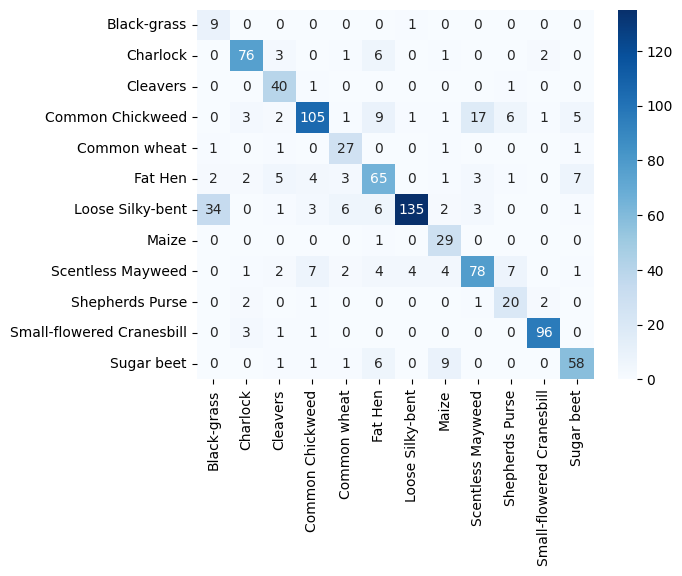

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.7635, accuracy:  0.8145
Validation - loss:  0.8055, accuracy:  0.7947


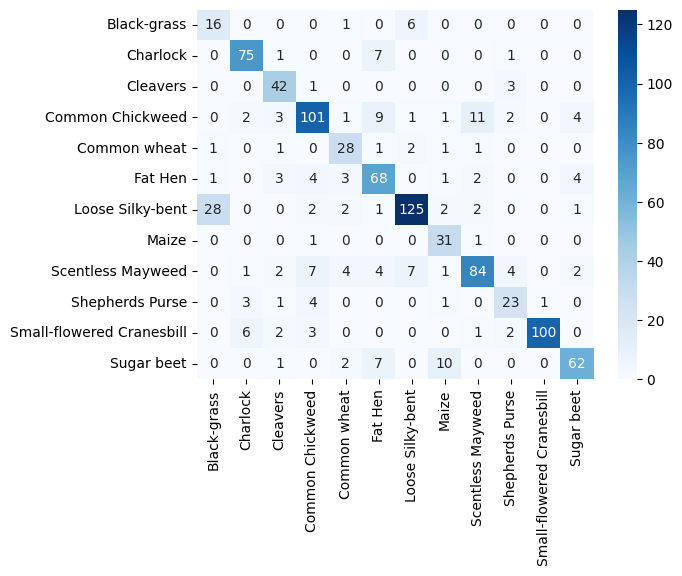

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.6659, accuracy:  0.8382
Validation - loss:  0.7523, accuracy:  0.8095


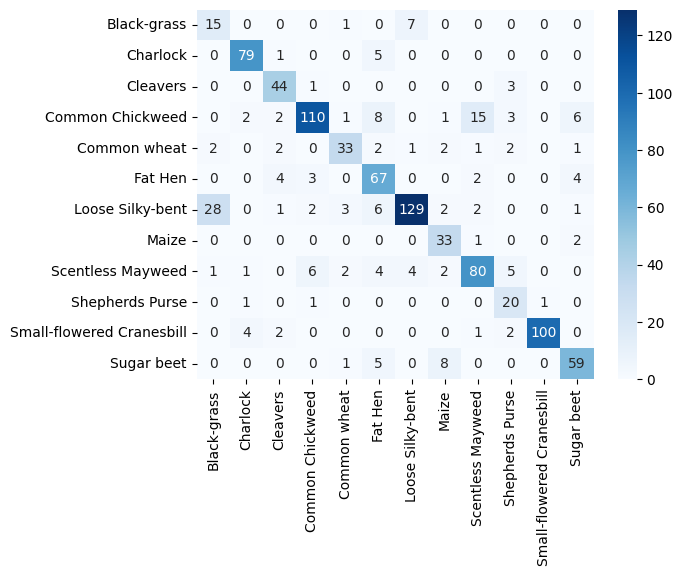

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5961, accuracy:  0.8537
Validation - loss:  0.7207, accuracy:  0.8042


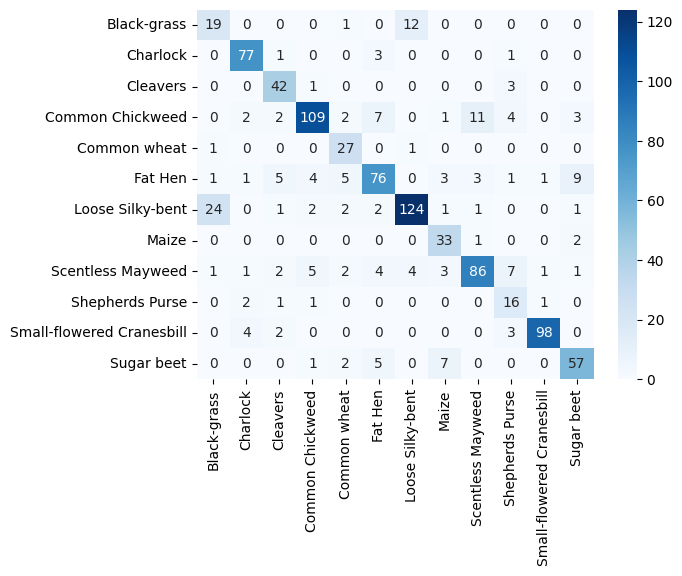

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5442, accuracy:  0.8658
Validation - loss:  0.6605, accuracy:  0.8042


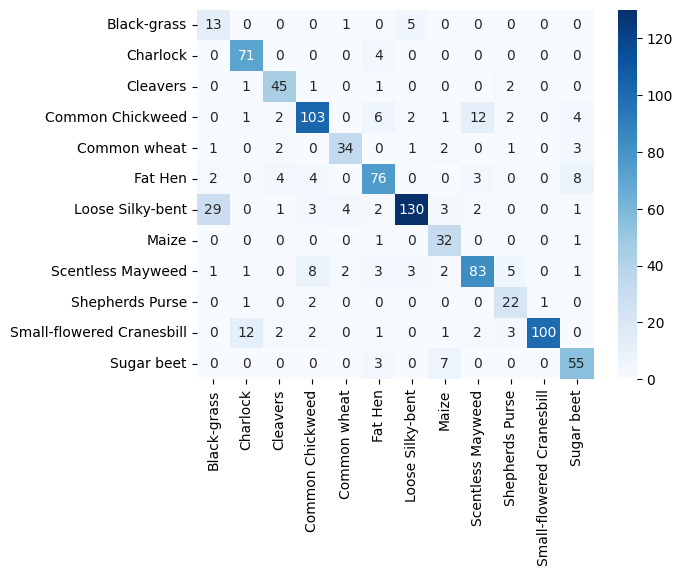

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5005, accuracy:  0.8803
Validation - loss:  0.6385, accuracy:  0.8168


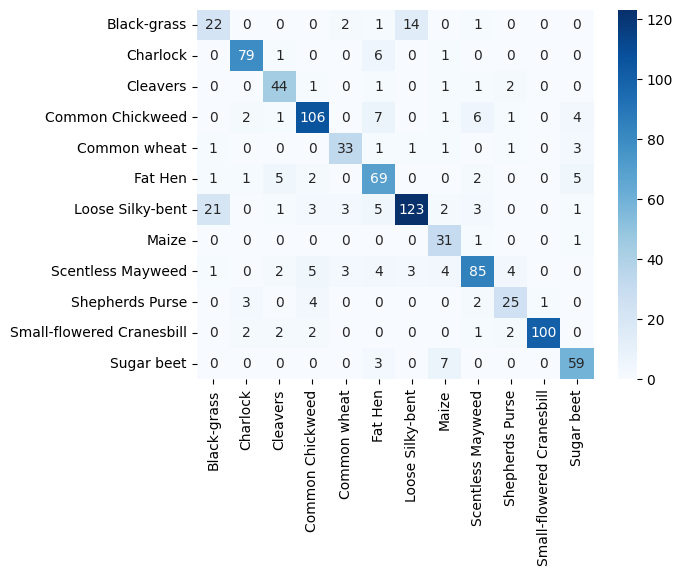

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4569, accuracy:  0.8861
Validation - loss:  0.6045, accuracy:  0.8316


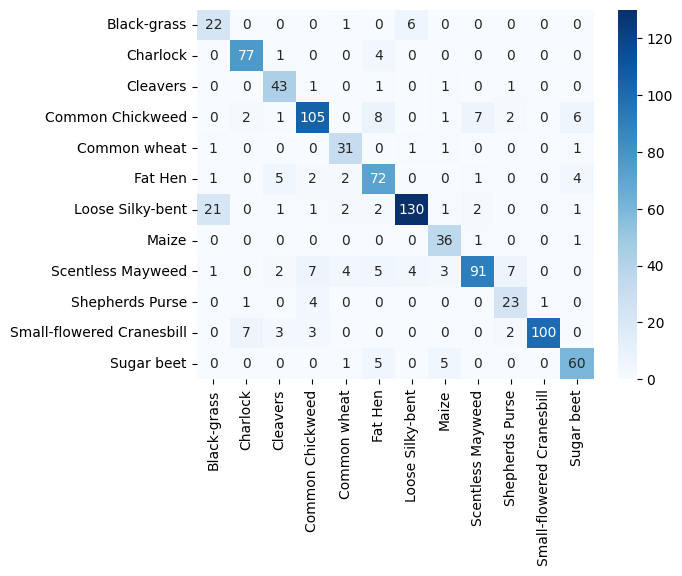

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4342, accuracy:  0.8947
Validation - loss:  0.5975, accuracy:  0.8295


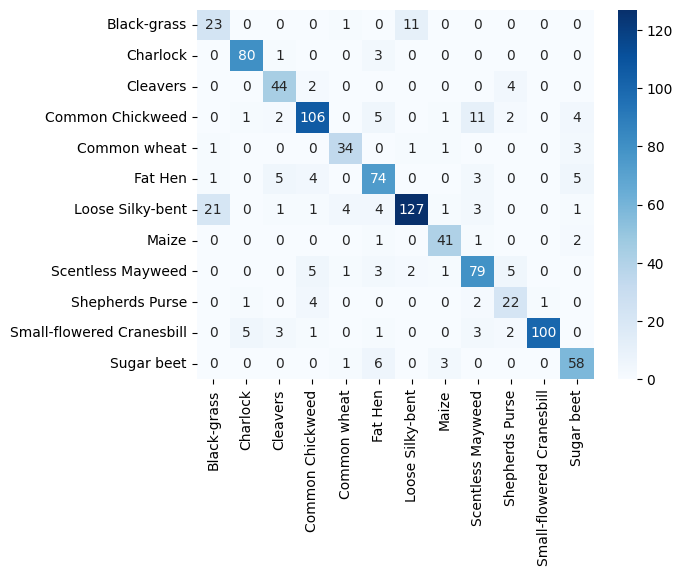

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4089, accuracy:  0.9042
Validation - loss:  0.5822, accuracy:  0.8347


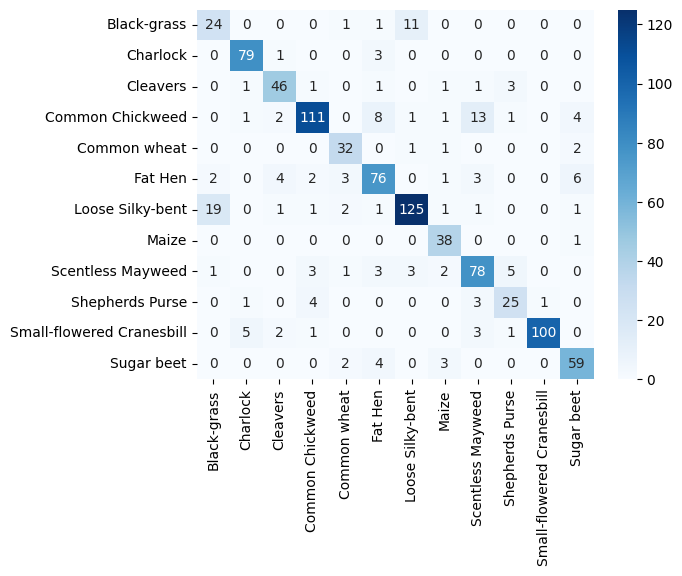

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3847, accuracy:  0.9100
Validation - loss:  0.5780, accuracy:  0.8316


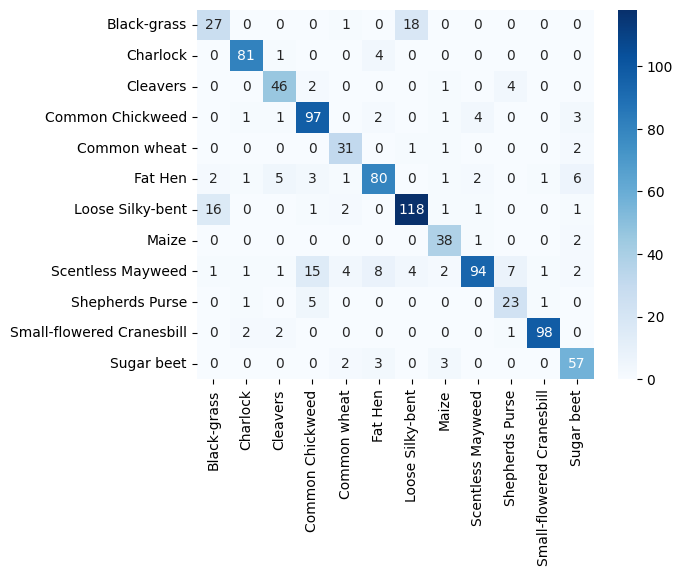

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3604, accuracy:  0.9158
Validation - loss:  0.5454, accuracy:  0.8484


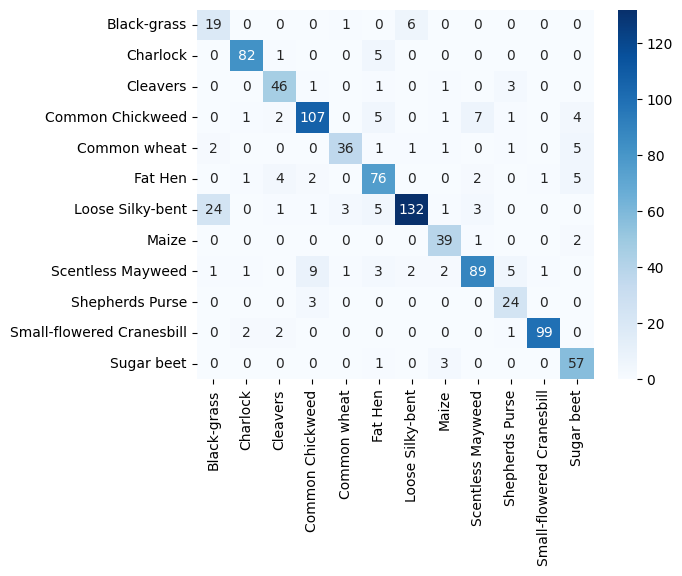

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3295, accuracy:  0.9239
Validation - loss:  0.5383, accuracy:  0.8379


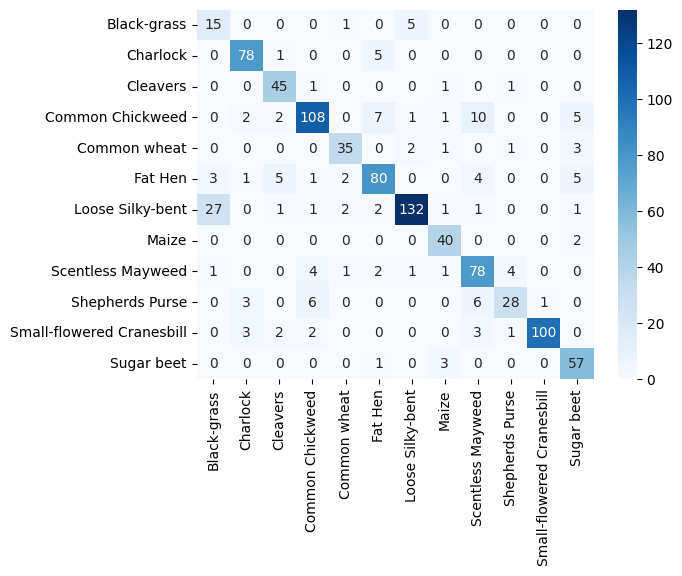

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3126, accuracy:  0.9289
Validation - loss:  0.5389, accuracy:  0.8368


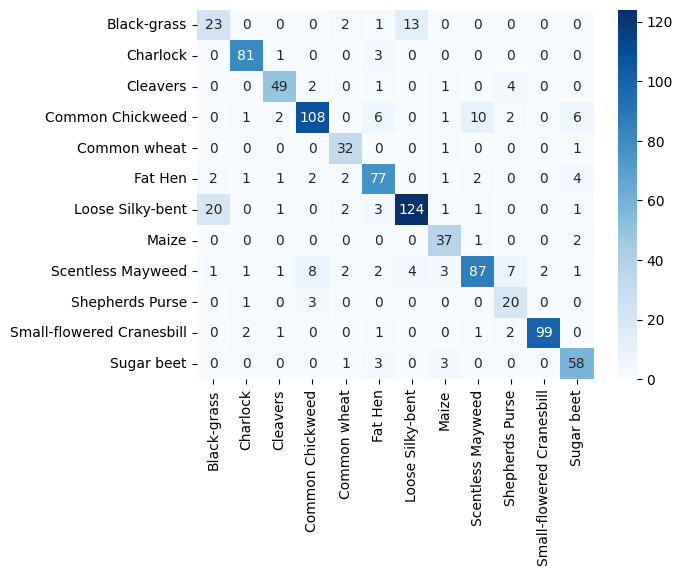

----------------------------------------------------------------------------------------------------
Fold 5 / 5
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.7885, accuracy:  0.4921
Validation - loss:  1.3377, accuracy:  0.6453


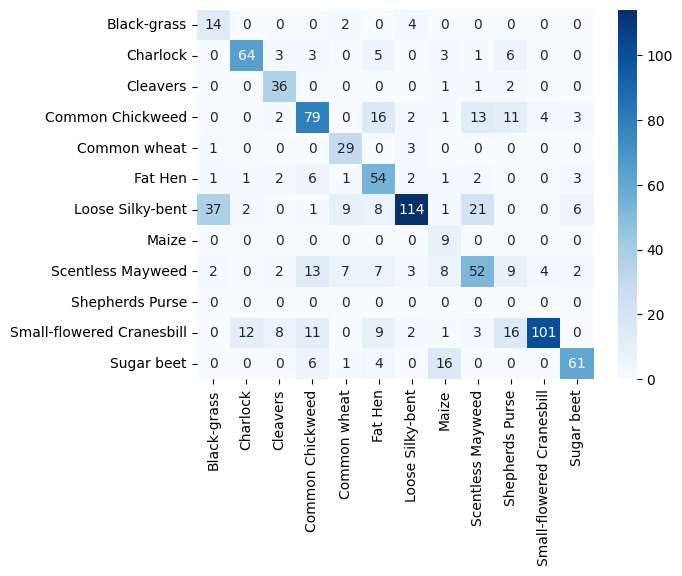

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  1.1771, accuracy:  0.6950
Validation - loss:  0.9992, accuracy:  0.7242


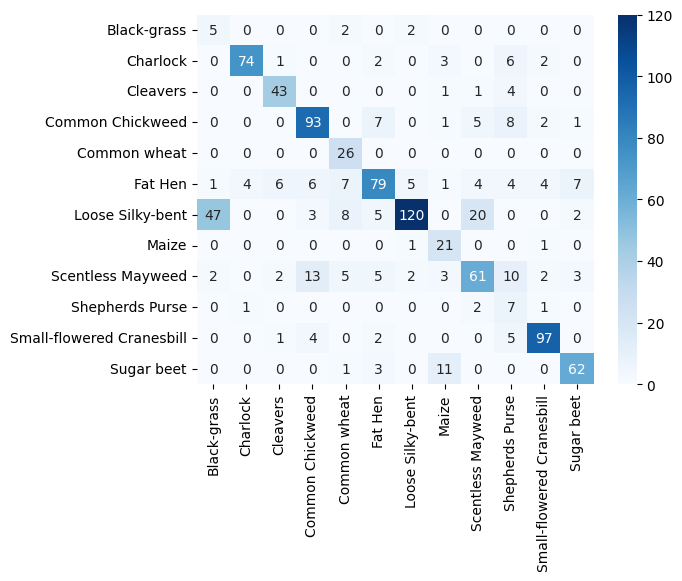

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.9363, accuracy:  0.7626
Validation - loss:  0.8726, accuracy:  0.7621


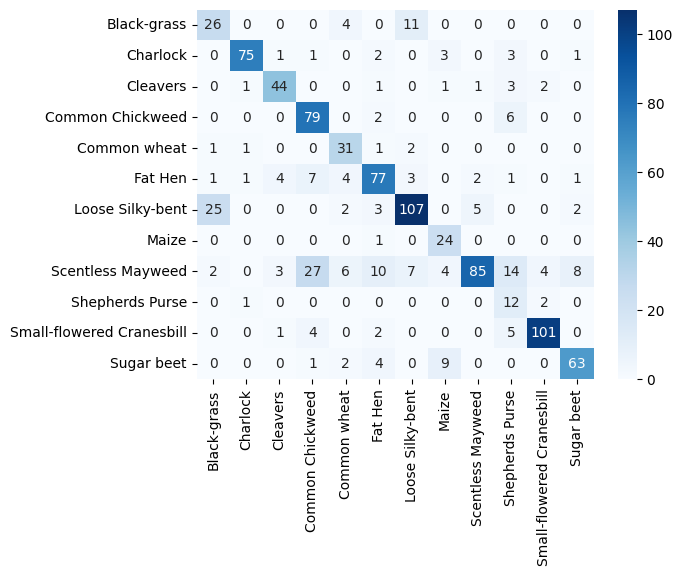

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.7937, accuracy:  0.7939
Validation - loss:  0.7605, accuracy:  0.8137


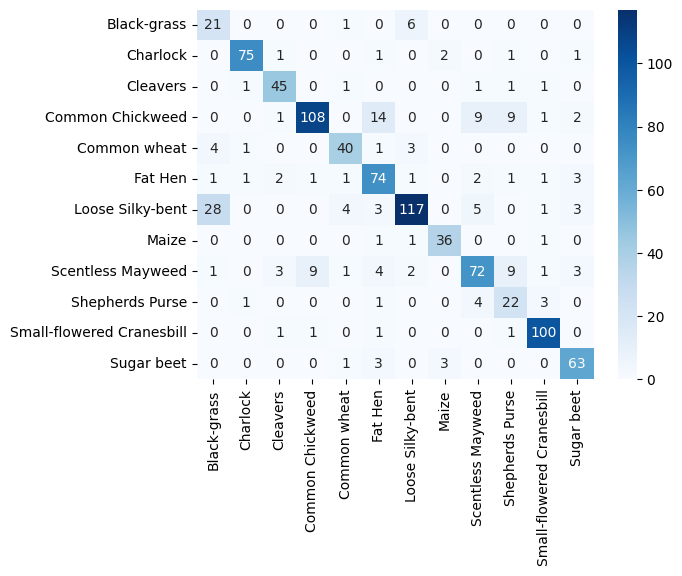

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.6800, accuracy:  0.8282
Validation - loss:  0.7169, accuracy:  0.8042


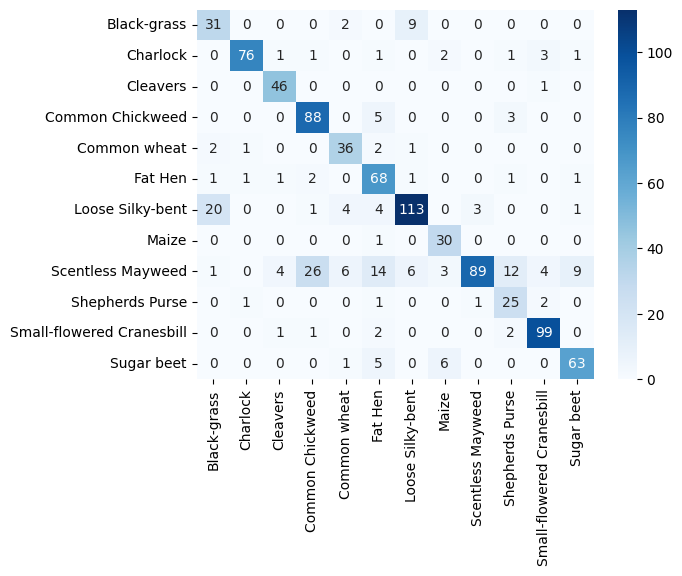

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.6205, accuracy:  0.8487
Validation - loss:  0.6445, accuracy:  0.8337


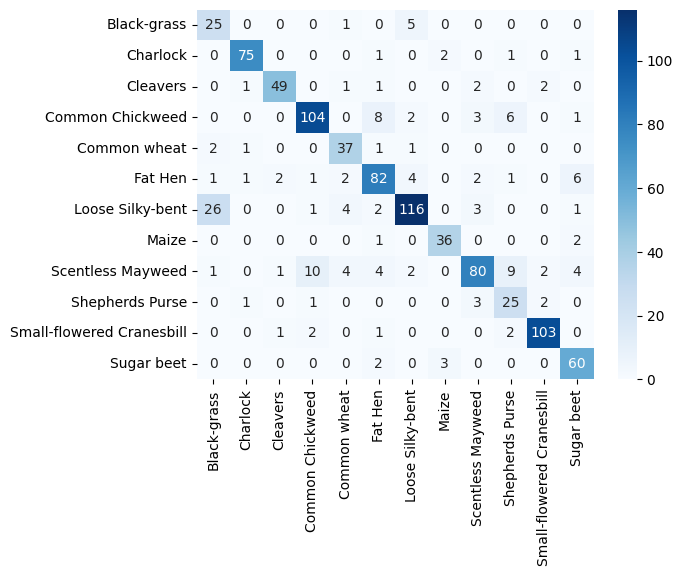

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5560, accuracy:  0.8605
Validation - loss:  0.6066, accuracy:  0.8400


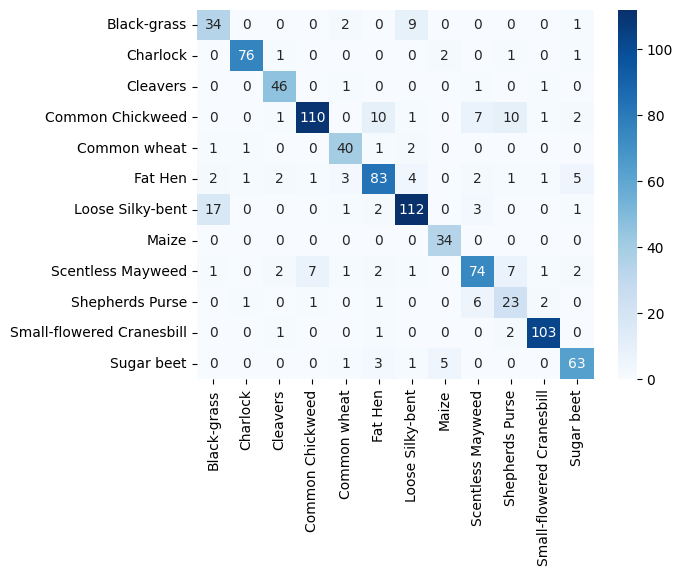

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.5141, accuracy:  0.8734
Validation - loss:  0.5663, accuracy:  0.8421


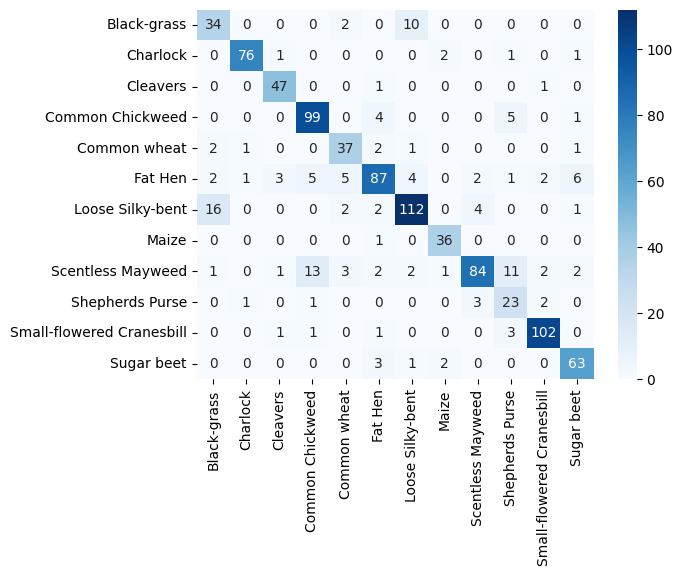

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4690, accuracy:  0.8889
Validation - loss:  0.5556, accuracy:  0.8484


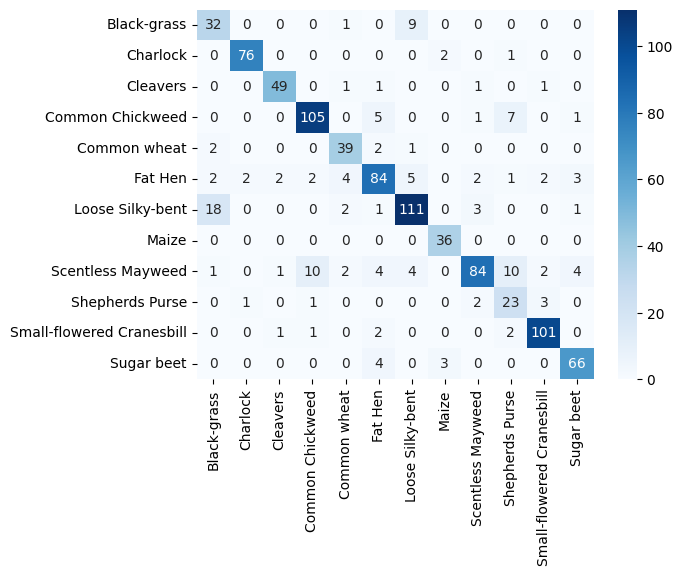

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4416, accuracy:  0.8921
Validation - loss:  0.5287, accuracy:  0.8537


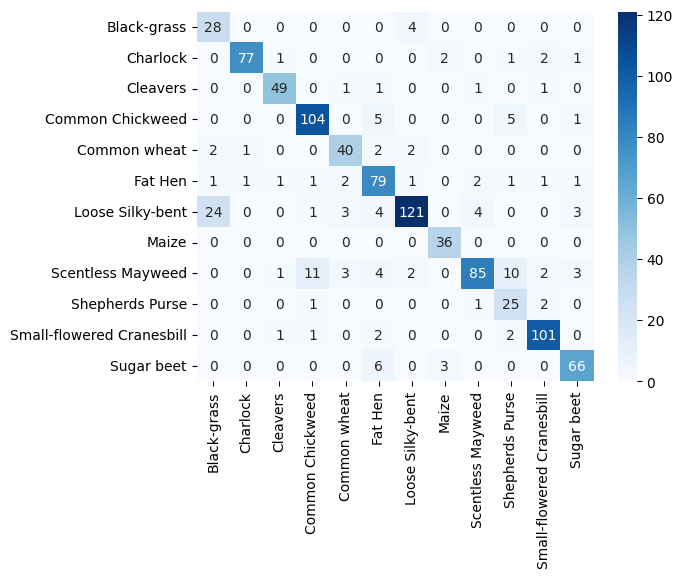

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.4125, accuracy:  0.9026
Validation - loss:  0.5348, accuracy:  0.8537


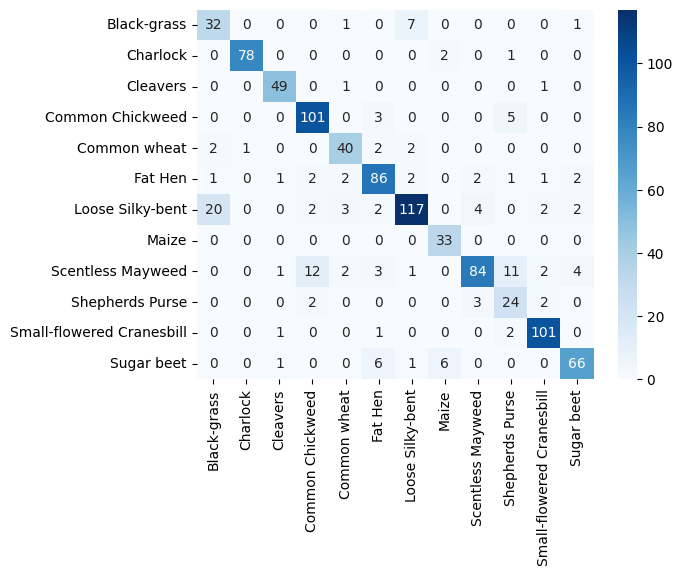

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3917, accuracy:  0.9092
Validation - loss:  0.5013, accuracy:  0.8484


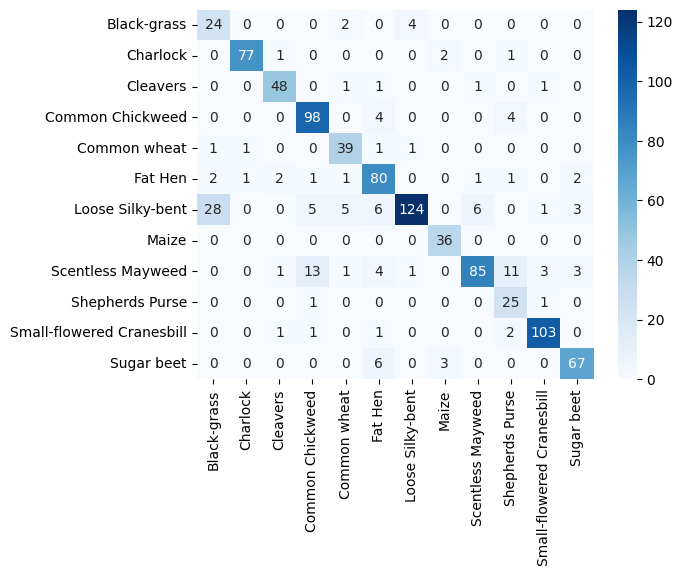

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3654, accuracy:  0.9147
Validation - loss:  0.4952, accuracy:  0.8621


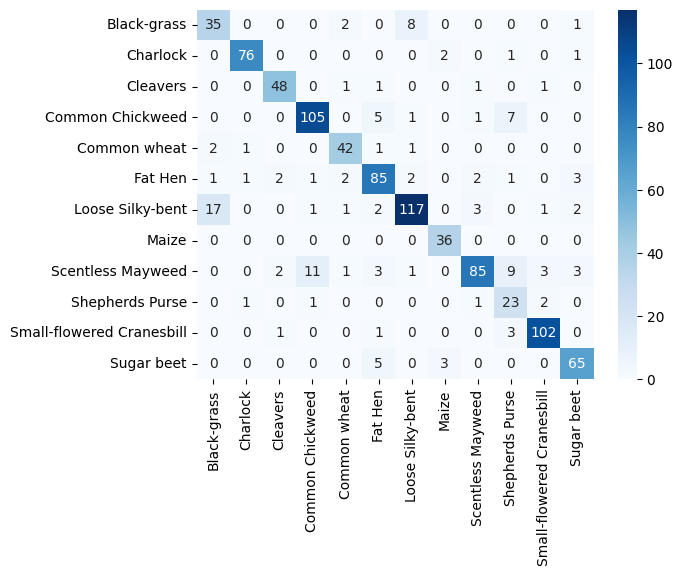

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3342, accuracy:  0.9279
Validation - loss:  0.4677, accuracy:  0.8632


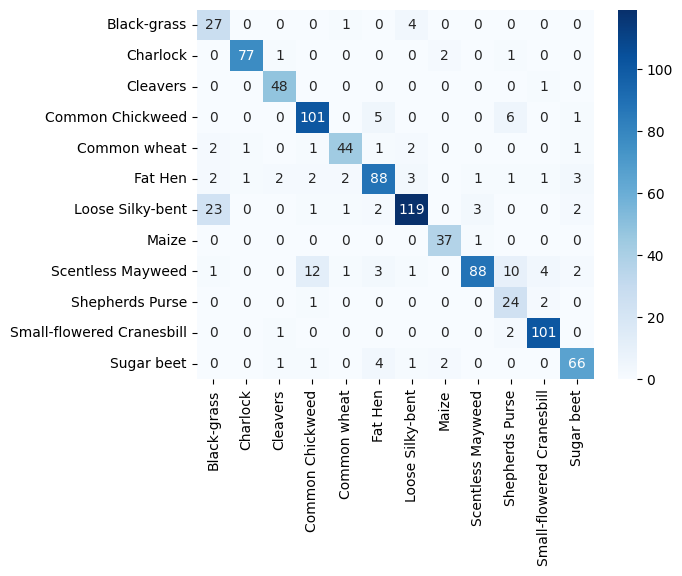

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/119 [00:00<?, ?it/s]

Train - loss:  0.3337, accuracy:  0.9263
Validation - loss:  0.4678, accuracy:  0.8600


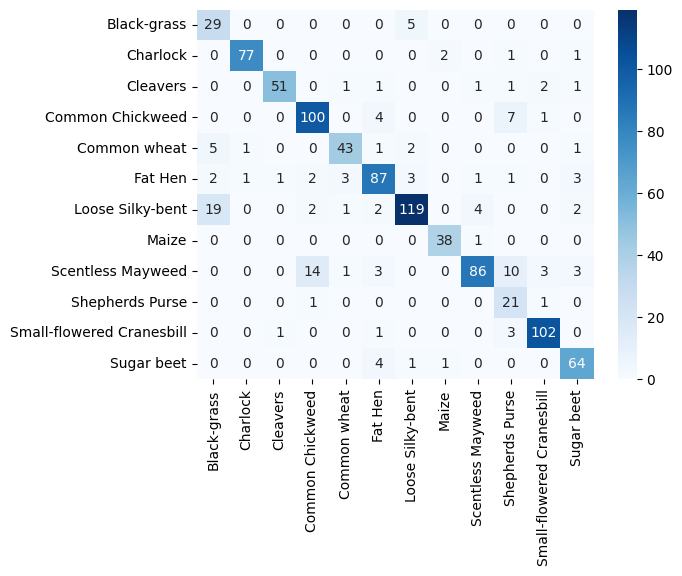

----------------------------------------------------------------------------------------------------


In [5]:
n_folds, n_epochs = 5, 15
train_loss, val_loss, train_acc, val_acc = train(device, dataset, len(dataset.classes), n_folds, n_epochs)

# Draw training / validation loss curve

In [6]:
def draw_loss_curve(train_loss, val_loss, n_folds, n_epochs):
    x = [i for i in range(1, n_epochs + 1)]
    
    plt.plot(x, train_loss, linestyle = "-", color = "red", label = "train_loss")
    plt.plot(x, val_loss, linestyle = "--", color = "blue", label = "val_loss")
    plt.title(f"Training / Validation Loss Curve of Fold {n_folds}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"k-fold validation/loss_curve_fold {n_folds}.png")
    plt.show()

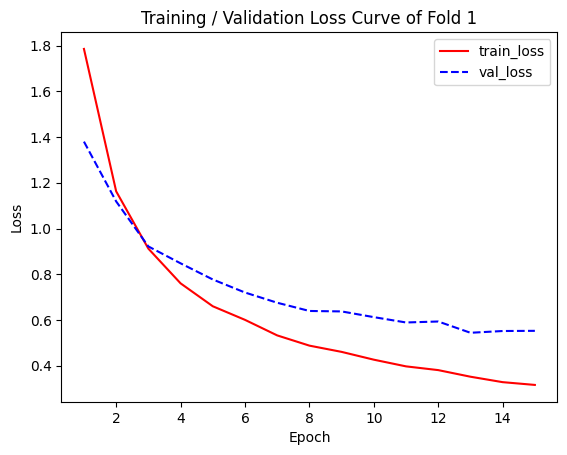

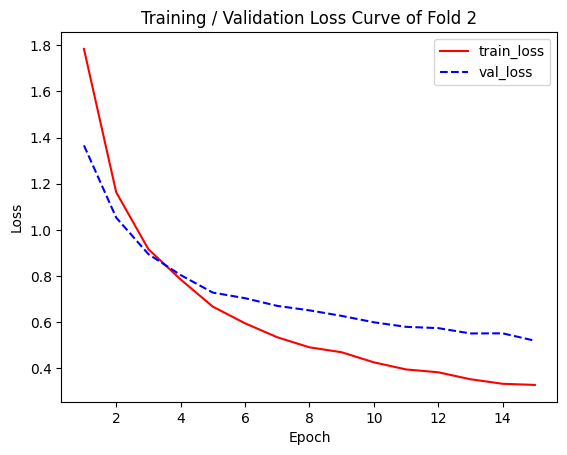

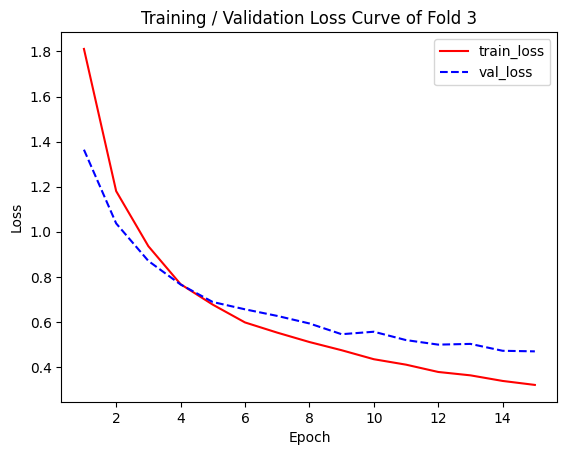

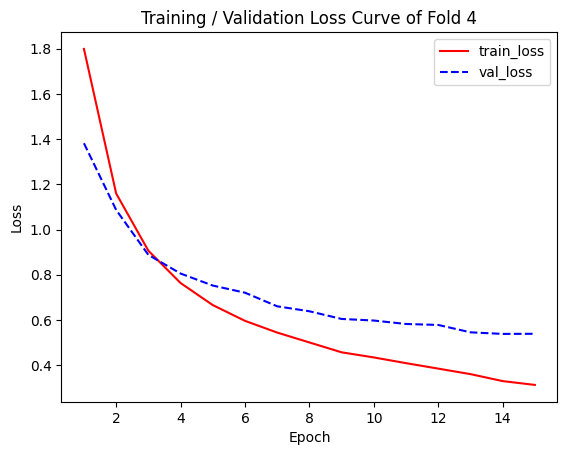

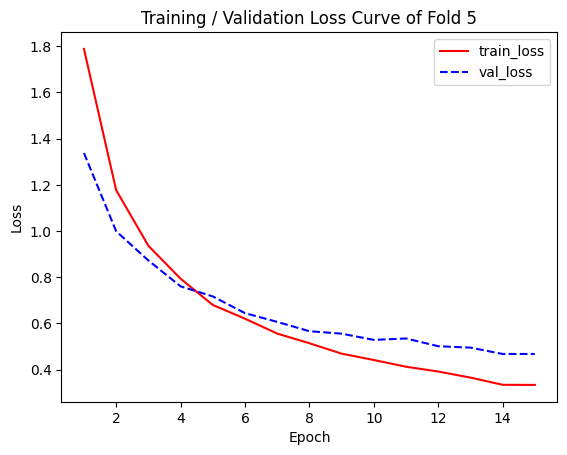

In [7]:
for n in range(n_folds):
    draw_loss_curve(train_loss[n], val_loss[n], n + 1, n_epochs)

# Select the best model

In [8]:
i = val_acc.index(max(val_acc))

model = resnet50().to(device)
for parameter in model.parameters():
    parameter.require_grad = False
model.fc = torch.nn.Linear(2048, len(dataset.classes)).to(device)

if torch.cuda.is_available():
    weigths = torch.load(f"model_weights/model_weights_fold {i + 1} (k-fold validation).pth", map_location = "cuda", weights_only = True)
elif torch.backends.mps.is_available():
    weights = torch.load(f"model_weights/model_weights_fold {i + 1} (k-fold validation).pth", map_location = "mps", weights_only = True)
else:
    weights = torch.load(f"model_weights/model_weights_fold {i + 1} (k-fold validation).pth", map_location = "cpu", weights_only = True)
    
model.load_state_dict(weights)

<All keys matched successfully>

The best model is the model of fold 3
Training accuracy:  0.9332, Validation accuracy:  0.8642


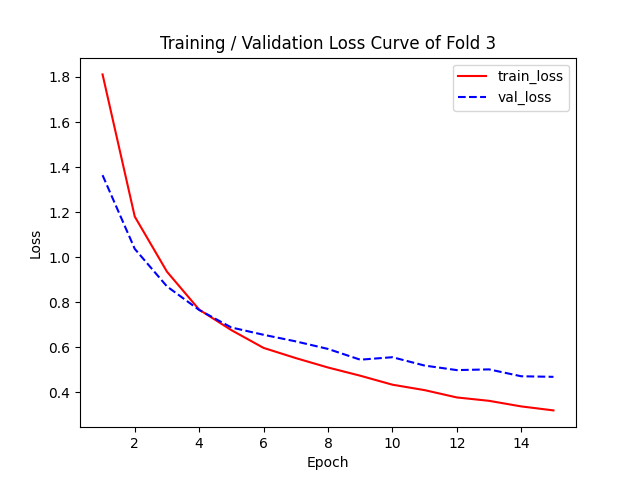

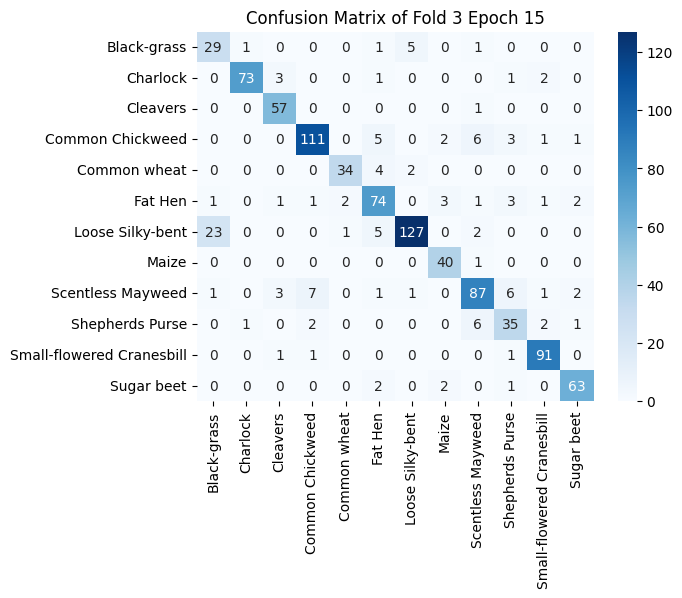

In [9]:
from IPython.display import Image

print(f"The best model is the model of fold {i + 1}")
print(f"Training accuracy: {train_acc[i]: .4f}, Validation accuracy: {val_acc[i]: .4f}")

loss_curve = Image(f"k-fold validation/loss_curve_fold {i + 1}.png")
confusion_matrix = Image(f"k-fold validation/confusion matrix_fold {i + 1}_epoch {n_epochs}.png")
display(loss_curve)
display(confusion_matrix)

# Do prediction & write submission file

In [10]:
import os

from torch.utils.data import Dataset
from torchvision.io import read_image

class TestImageDataset(Dataset):
    def __init__(self, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_name = self.img_path[idx].split("/")[-1]
        image = read_image(self.img_path[idx])
        if self.transform:
            image = self.transform(image)

        return image_name, image

In [11]:
@torch.no_grad()
def test(model, device, test_loader, mapping_dict):
    model.eval()
    predictions = []
    with tqdm(test_loader) as loader:
        loader.set_description("Testing")
        for image_name, inputs in loader:
            inputs = inputs.to(device, non_blocking = True)
    
            # forward
            outputs = model(inputs)
    
            # evaluation
            pred = outputs.argmax(dim = 1, keepdim = True)[0][0]
            pred = mapping_dict[pred.item()]
            predictions.append((image_name[0], pred))

    return predictions

In [12]:
import glob

testing_set = TestImageDataset(glob.glob("dataset/test/*.png"), transforms)
test_loader = DataLoader(testing_set)
mapping_dict = {i: label for i, label in enumerate(dataset.classes)}
prediction = test(model, device, test_loader, mapping_dict)

  0%|          | 0/794 [00:00<?, ?it/s]

In [13]:
with open("prediction/submission (k-fold validation).csv", "w") as file:
    file.write("file,species\n")
    for image_name, pred in prediction:
        file.write(f"{image_name},{pred}\n")